<font color="#CC3D3D"><p>
# ML Pipeline

- **`PROBLEM`**: 백화점 고객이 1년 동안 상품을 구매한 속성을 분석하여 `고객의 성별(0:여자, 1:남자)을 예측`하시오.
- **`INPUT`**: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- **`OUTPUT`**: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

##### Imports

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
!pip install klib

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline
plt.rc('font',family='Malgun Gothic')
from matplotlib import font_manager, rc
pd.set_option('max_columns', 30, 'max_rows', 20)

# EDA
import klib

# Data Split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
seed = 42
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn import model_selection

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
import optuna

# Modeling
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import warnings

### 1. Read Data

In [2]:
# 학습용과 평가용(제출용) 데이터를 읽어들인다.
train = pd.read_csv(r'X_train.csv', encoding='euc-kr')
test = pd.read_csv(r'X_test.csv', encoding='euc-kr')

# 분석에 필요없는 ID 필드를 데이터에서 제거하고, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 ID는 보관한다.
train_id = train['cust_id']
test_id = test['cust_id']
del train['cust_id'], test['cust_id']

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv(r'y_train.csv', encoding='euc-kr').gender

- 학습용 데이터와 테스트 데이터 분리 후 진행

In [3]:
train

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16
4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85
...,...,...,...,...,...,...,...,...,...
3495,3175200,3042900,NaN,골프,본 점,1,2.000000,1.000000,0
3496,29628600,7200000,6049600.0,시티웨어,부산본점,8,1.625000,0.461538,40
3497,75000,75000,NaN,주방용품,창원점,1,1.000000,0.000000,0
3498,1875000,1000000,NaN,화장품,본 점,2,1.000000,0.000000,39


### 2. EDA

- 타겟 값의 불균형 정도 확인    여자(0) : 약 60%,  남자(1) : 약 40%    -> 약간의 불균형 데이터, stratifiedkfold 로 진행

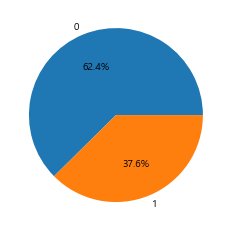

In [4]:
plt.pie(pd.DataFrame(y_train.value_counts())["gender"],labels=pd.DataFrame(y_train.value_counts()).index,autopct='%.1f%%')
plt.show()

In [5]:
#matplotlib 한글깨짐 지원

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

GridSpec(6, 6)

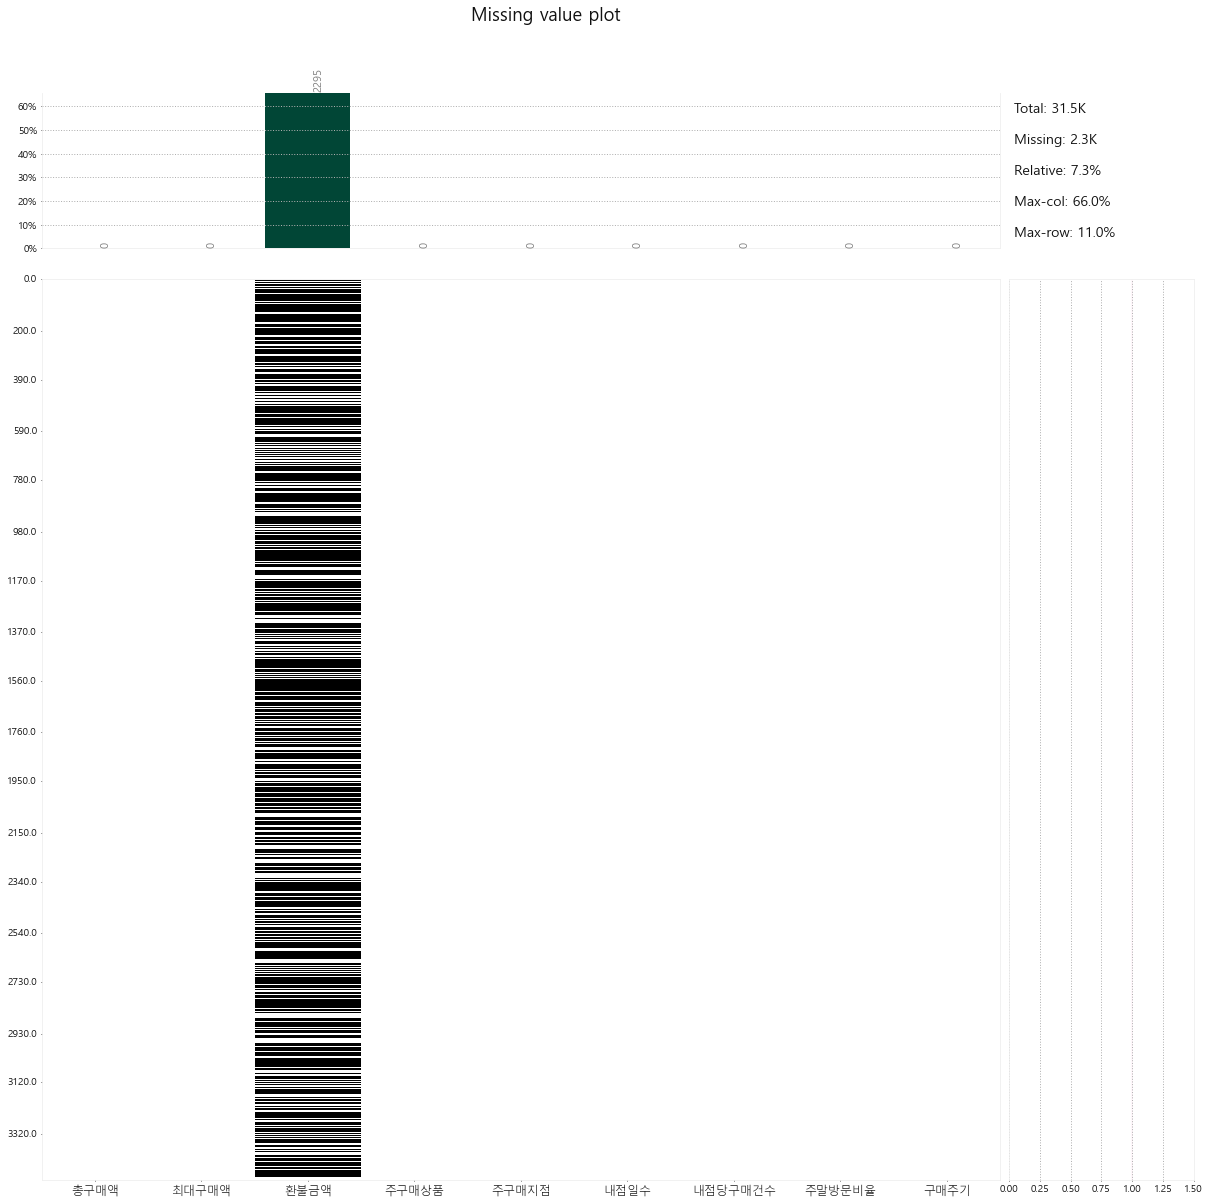

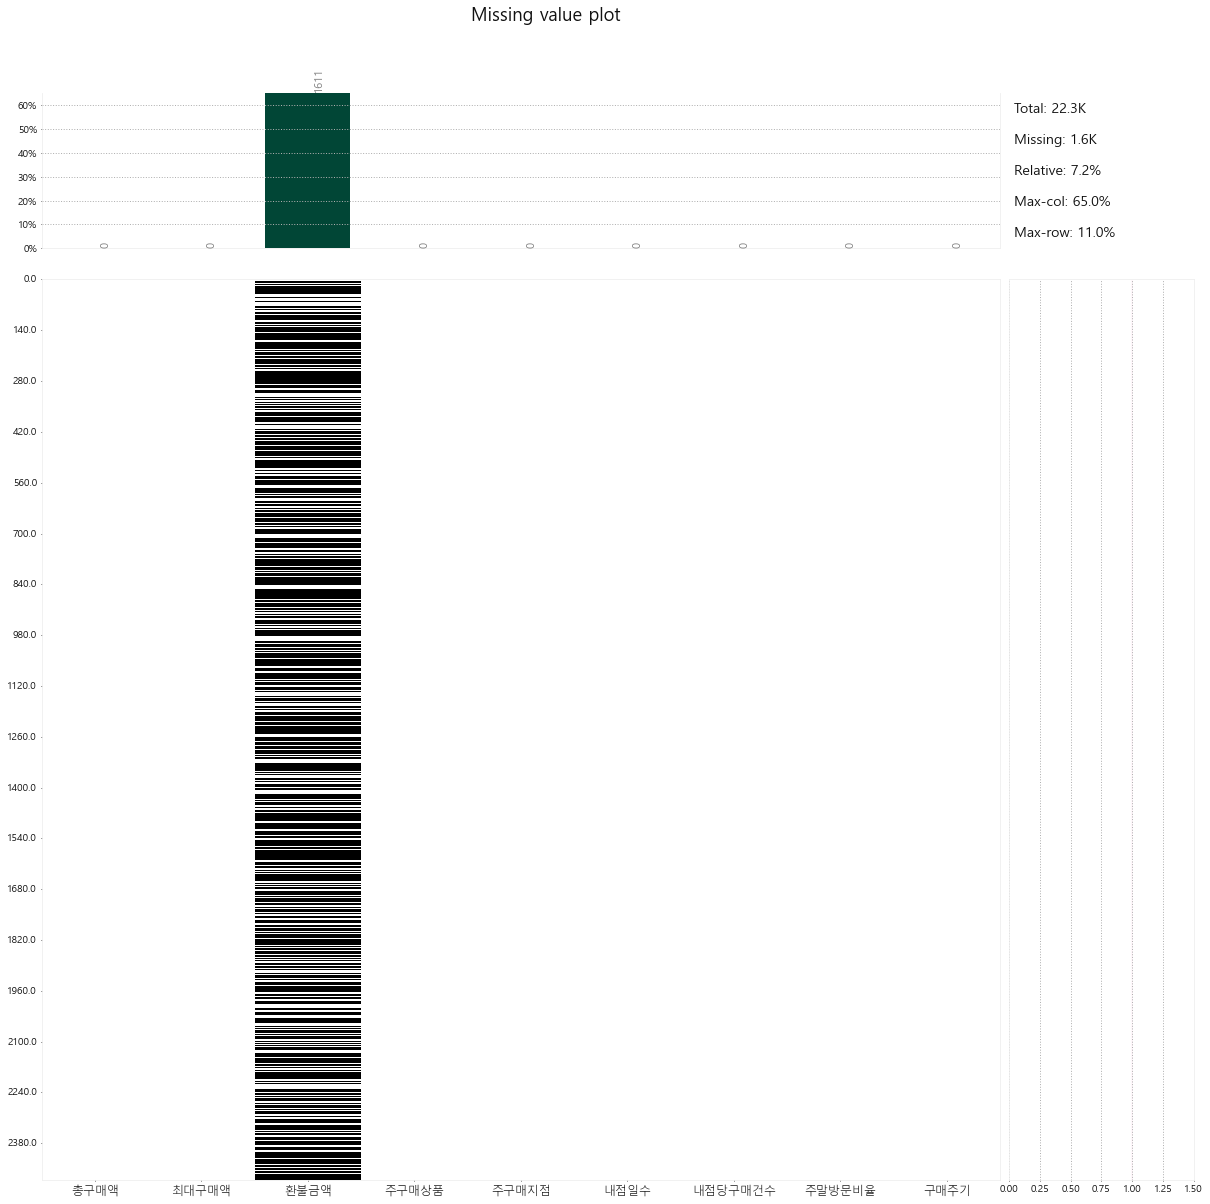

In [6]:
# 결측값 파악

klib.missingval_plot(train)
klib.missingval_plot(test)

<AxesSubplot:xlabel='구매주기', ylabel='Density'>

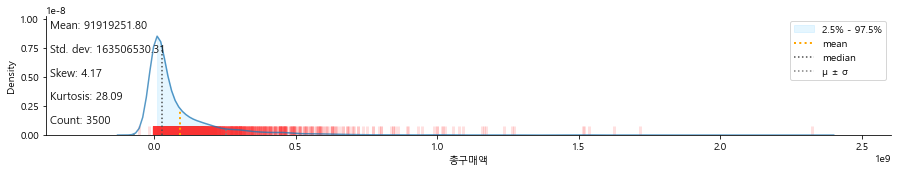

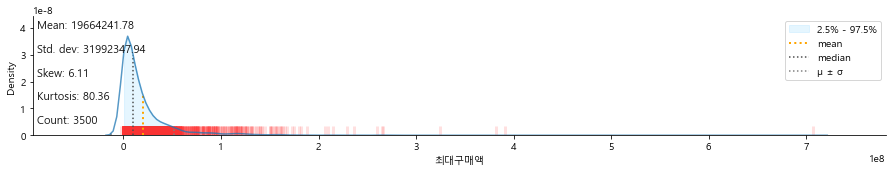

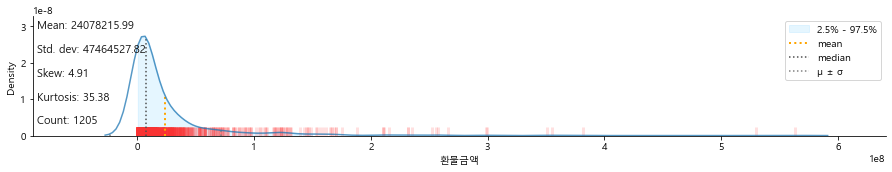

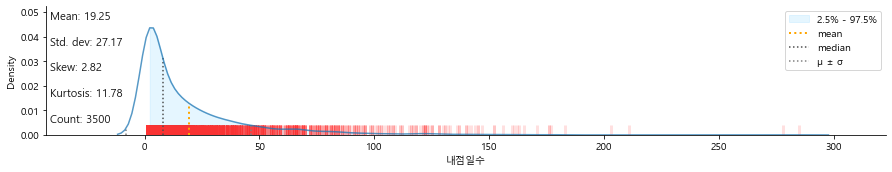

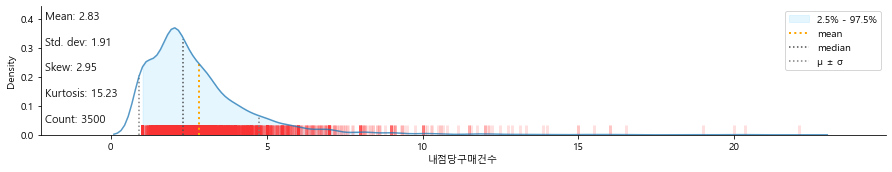

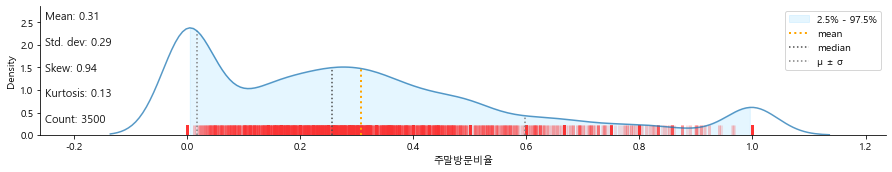

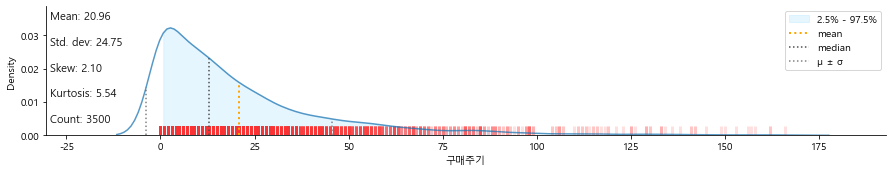

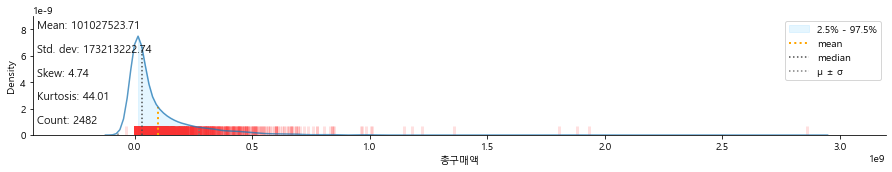

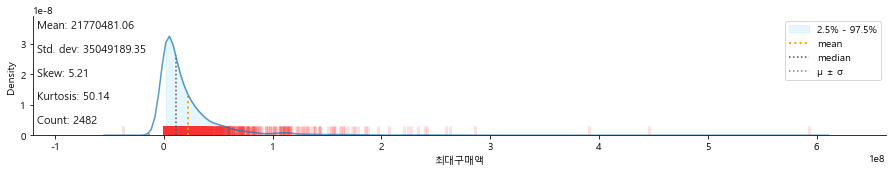

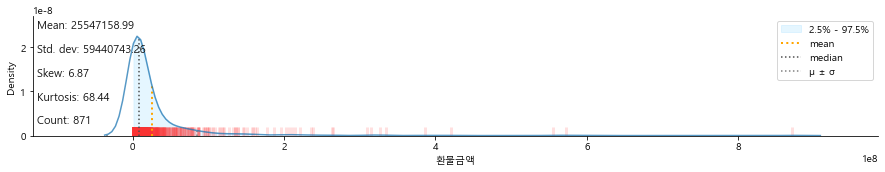

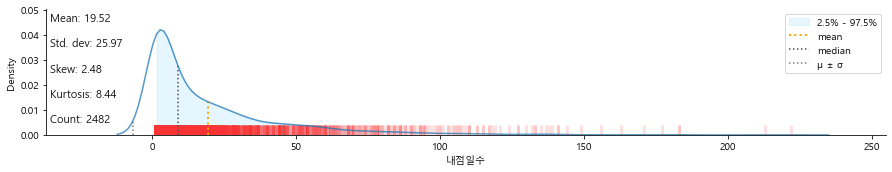

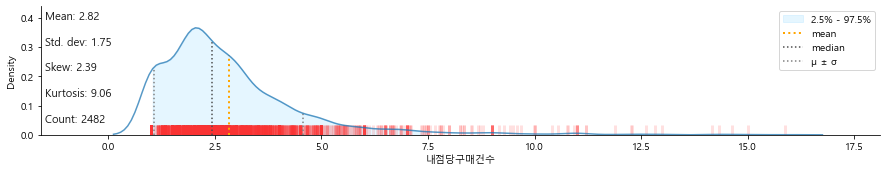

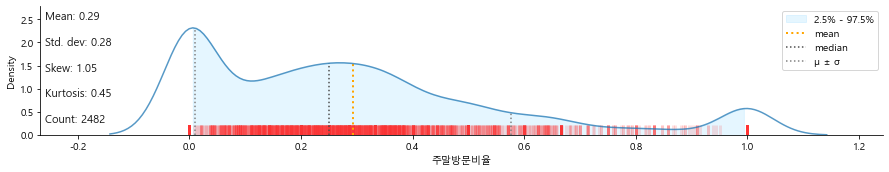

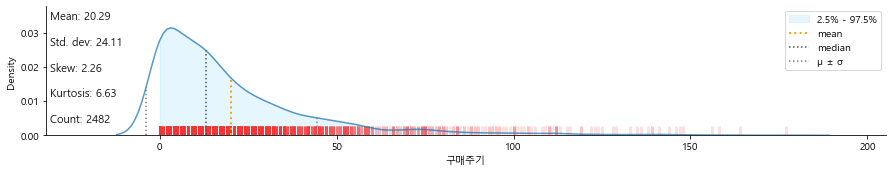

In [7]:
# 수치형 속성 파악

klib.dist_plot(train)
klib.dist_plot(test)

GridSpec(6, 2)

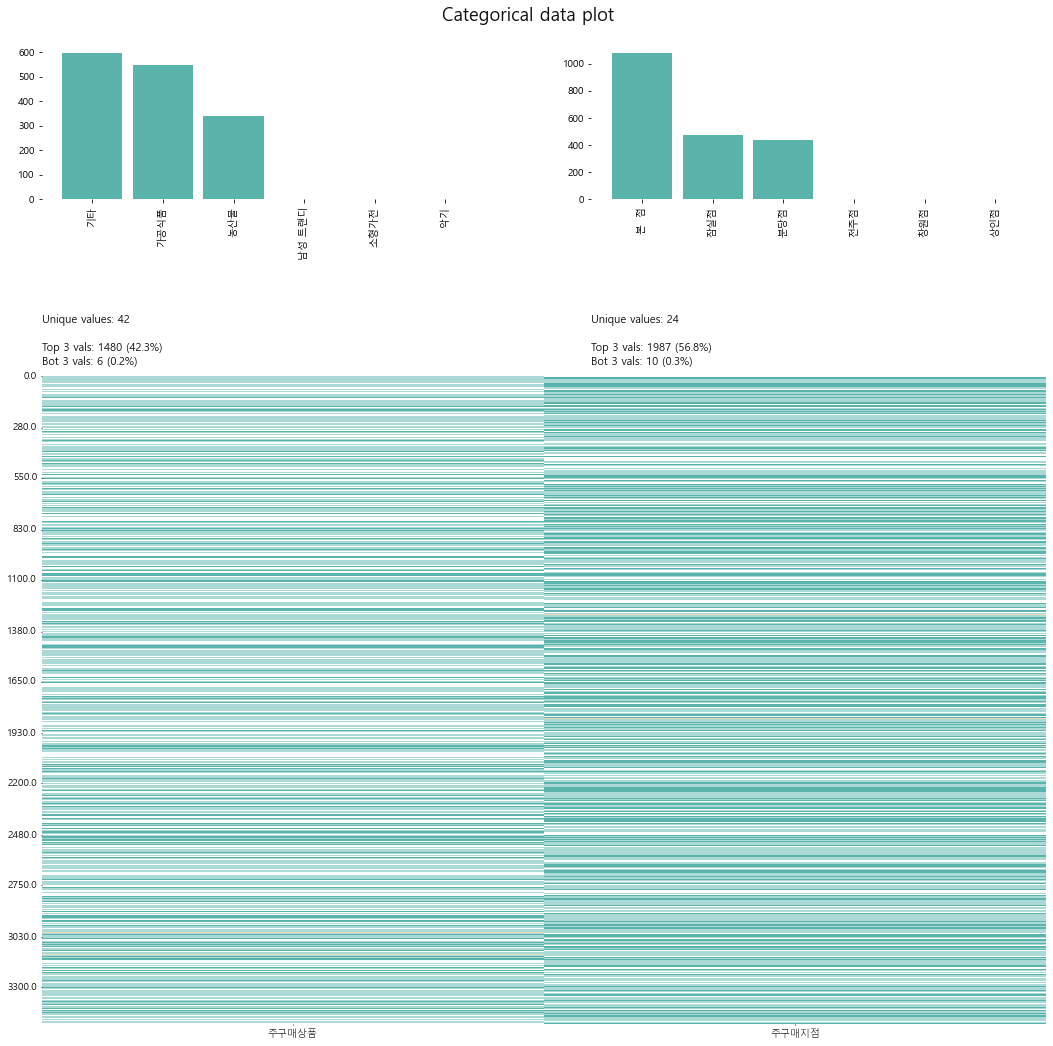

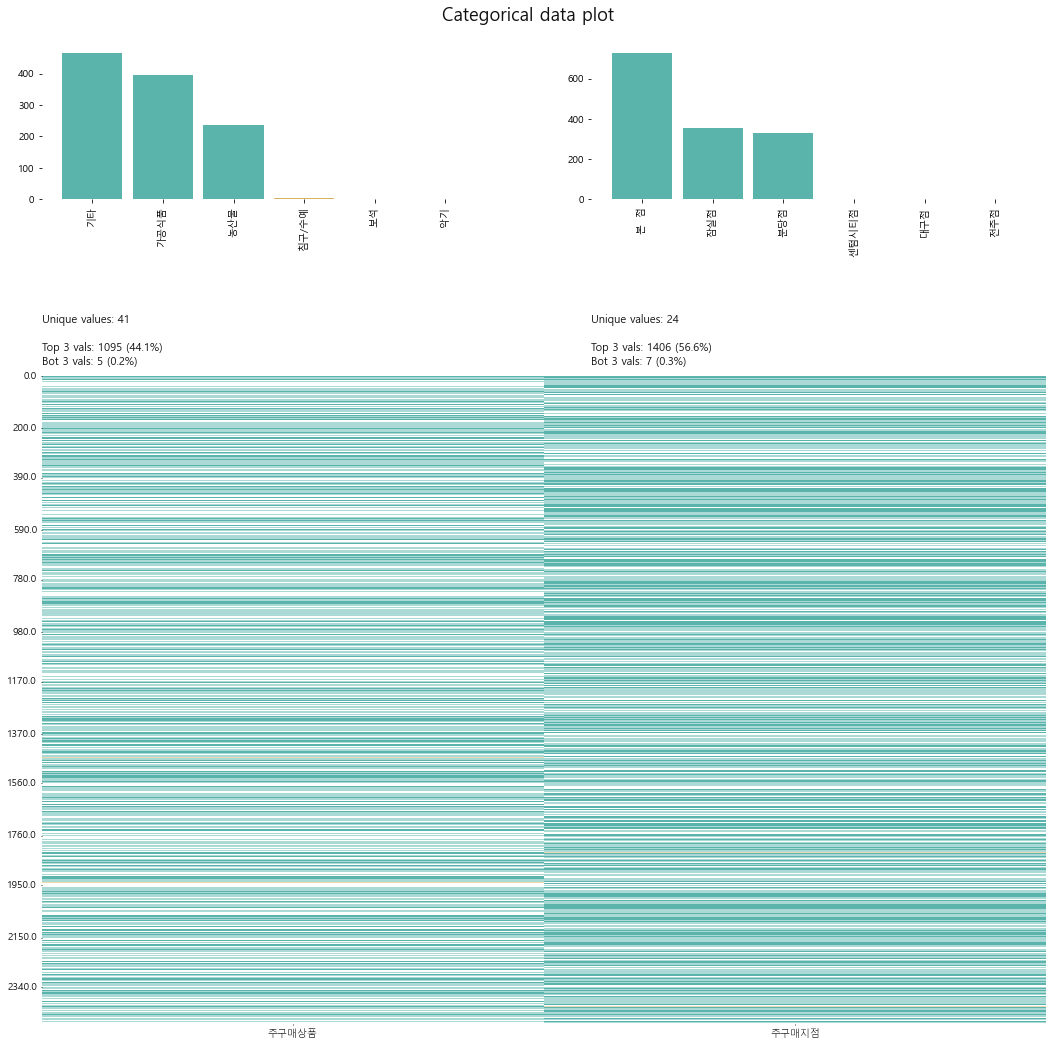

In [8]:
# 범주형 속성 파악

klib.cat_plot(train)
klib.cat_plot(test)

Displaying absolute correlations above the threshold (0.3). Specify a positive "threshold" to limit the results further.
Displaying absolute correlations above the threshold (0.3). Specify a positive "threshold" to limit the results further.


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

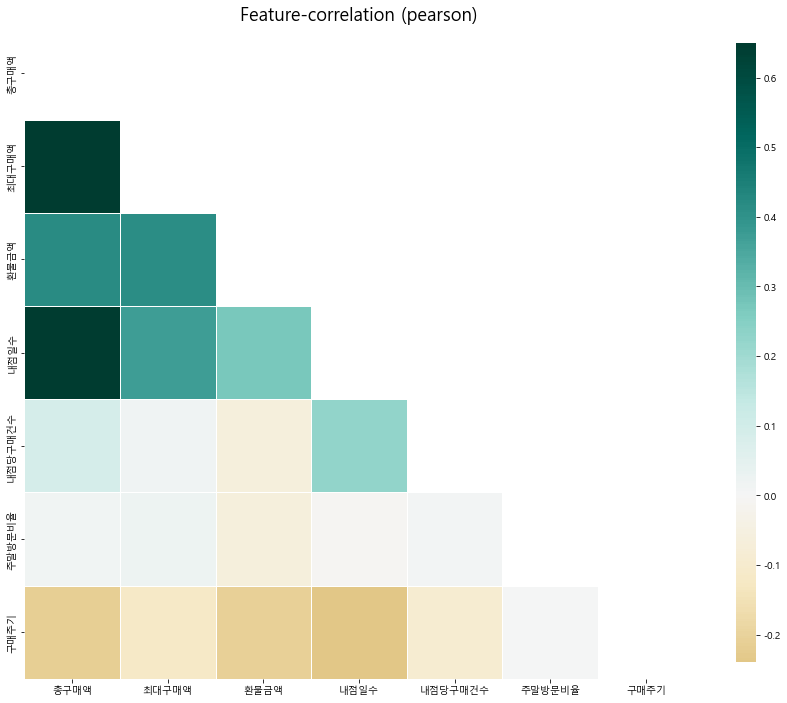

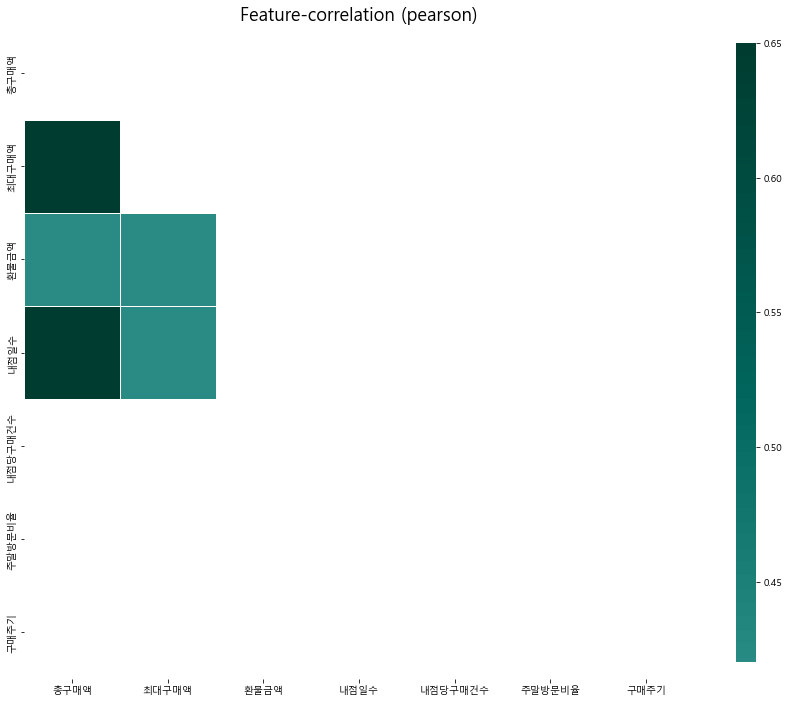

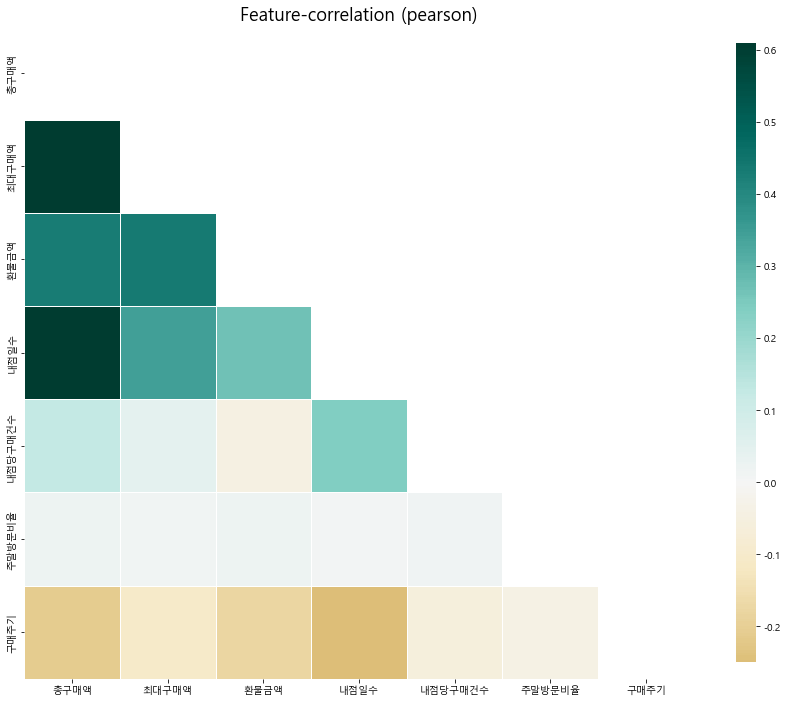

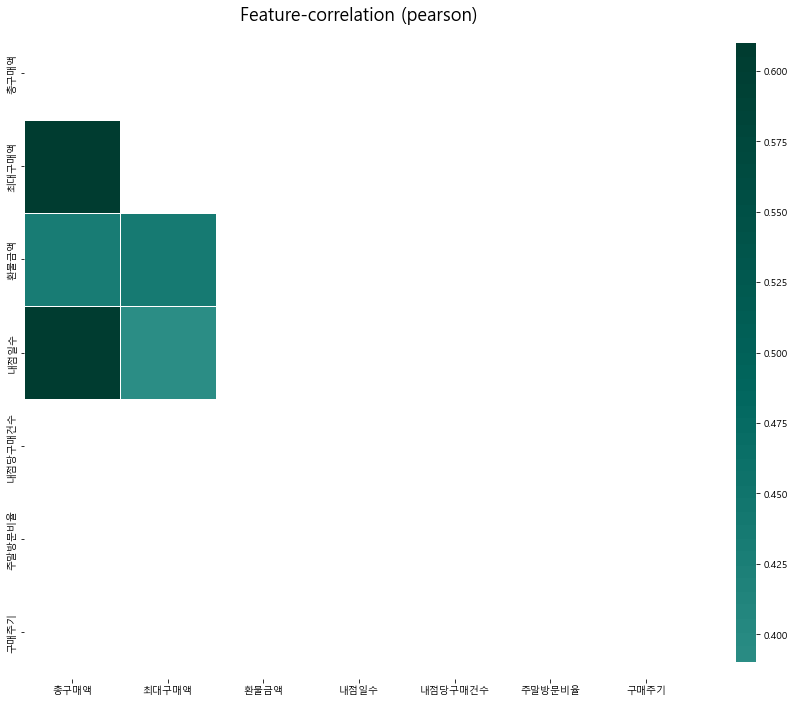

In [9]:
# 속성간 유사성 파악

klib.corr_plot(train, annot=False, figsize=(15,12))
klib.corr_plot(train, split='high', annot=False, figsize=(15,12))

klib.corr_plot(test, annot=False, figsize=(15,12))
klib.corr_plot(test, split='high', annot=False, figsize=(15,12))

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

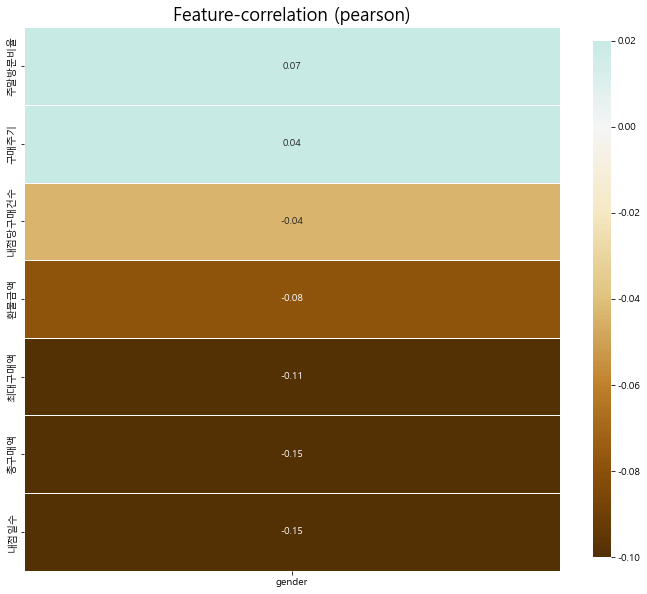

In [10]:
# 속성별 예측 능력 파악 

klib.corr_plot(pd.concat([train, y_train], axis=1), target='gender')

### 3. Data Cleansing & Feature Engineering

In [11]:
# 범주형 변수와 수치형 변수를 분리

cat_features = train.select_dtypes(include=['object']).columns.to_list()
num_features = train.select_dtypes(exclude='object').columns.to_list()
#num_features = [c for c in features.columns.tolist() if c not in cat_features]  

*Impute Missing Values*

In [12]:
# 결측값 처리: 범주형이냐 수치형이냐에 따라 다르게 처리

if len(num_features) > 0: 
    train[num_features] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(train[num_features])
if len(cat_features) > 0:  
    train[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(train[cat_features])

# 결측값 처리: 범주형이냐 수치형이냐에 따라 다르게 처리

if len(num_features) > 0: 
    test[num_features] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(test[num_features])
if len(cat_features) > 0:  
    test[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(test[cat_features])

train

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840.0,11264000.0,6860000.0,기타,강남점,19.0,3.894737,0.527027,17.0
1,2136000.0,2136000.0,300000.0,스포츠,잠실점,2.0,1.500000,0.000000,1.0
2,3197000.0,1639000.0,0.0,남성 캐주얼,관악점,2.0,2.000000,0.000000,1.0
3,16077620.0,4935000.0,0.0,기타,광주점,18.0,2.444444,0.318182,16.0
4,29050000.0,24000000.0,0.0,보석,본 점,2.0,1.500000,0.000000,85.0
...,...,...,...,...,...,...,...,...,...
3495,3175200.0,3042900.0,0.0,골프,본 점,1.0,2.000000,1.000000,0.0
3496,29628600.0,7200000.0,6049600.0,시티웨어,부산본점,8.0,1.625000,0.461538,40.0
3497,75000.0,75000.0,0.0,주방용품,창원점,1.0,1.000000,0.000000,0.0
3498,1875000.0,1000000.0,0.0,화장품,본 점,2.0,1.000000,0.000000,39.0


*Deal with Outliers*

In [13]:
# 수치형 변수에 대해 이상치(outlier)를 처리

train[num_features] = train[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 수치형 변수에 대해 이상치(outlier)를 처리

test[num_features] = test[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

*Transform Features*

In [14]:
# 수치형 변수를 정규분포에 가깝게 만들기 + 표준화

train[num_features] = PowerTransformer(standardize=True).fit_transform(train[num_features])

# 수치형 변수를 정규분포에 가깝게 만들기 + 표준화

test[num_features] = PowerTransformer(standardize=True).fit_transform(test[num_features])
train

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,0.531625,0.156370,1.389715,기타,강남점,0.654560,0.973940,0.934300,0.281268
1,-1.105528,-0.870434,1.229086,스포츠,잠실점,-0.978358,-0.901725,-1.318185,-1.204195
2,-0.948080,-1.005669,-0.723938,남성 캐주얼,관악점,-0.978358,-0.345055,-1.318185,-1.204195
3,-0.235198,-0.394387,-0.723938,기타,광주점,0.614210,0.052062,0.301068,0.232035
4,0.062479,0.744338,-0.723938,보석,본 점,-0.978358,-0.901725,-1.318185,1.705155
...,...,...,...,...,...,...,...,...,...
3495,-0.950816,-0.678608,-0.723938,골프,본 점,-1.367639,-0.345055,1.799465,-1.533610
3496,0.072771,-0.153156,1.384424,시티웨어,부산본점,0.003311,-0.748999,0.759341,1.069485
3497,-1.760093,-1.845989,-0.723938,주방용품,창원점,-1.367639,-1.637056,-1.318185,-1.533610
3498,-1.154802,-1.240203,-0.723938,화장품,본 점,-0.978358,-1.637056,-1.318185,1.043538


*Encode Categorical Variables*

In [15]:
# 범주형 변수에 One-Hot-Encoding 후 수치형 변수와 병합

if len(cat_features) > 0:
    train = pd.concat([train[num_features], pd.get_dummies(train[cat_features])], axis=1)
else:
    train = train[num_features]

if len(cat_features) > 0:
    test = pd.concat([test[num_features], pd.get_dummies(test[cat_features])], axis=1)
else:
    test = test[num_features]

train

,총구매액,최대구매액,환불금액,내점일수,내점당구매건수,주말방문비율,구매주기,주구매상품_가공식품,주구매상품_가구,주구매상품_건강식품,주구매상품_골프,주구매상품_구두,주구매상품_기타,주구매상품_남성 캐주얼,주구매상품_남성 트랜디,...,주구매지점_부산본점,주구매지점_부평점,주구매지점_분당점,주구매지점_상인점,주구매지점_센텀시티점,주구매지점_안양점,주구매지점_영등포점,주구매지점_울산점,주구매지점_인천점,주구매지점_일산점,주구매지점_잠실점,주구매지점_전주점,주구매지점_창원점,주구매지점_청량리점,주구매지점_포항점
0,0.531625,0.156370,1.389715,0.654560,0.973940,0.934300,0.281268,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1.105528,-0.870434,1.229086,-0.978358,-0.901725,-1.318185,-1.204195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,-0.948080,-1.005669,-0.723938,-0.978358,-0.345055,-1.318185,-1.204195,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.235198,-0.394387,-0.723938,0.614210,0.052062,0.301068,0.232035,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.062479,0.744338,-0.723938,-0.978358,-0.901725,-1.318185,1.705155,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,-0.950816,-0.678608,-0.723938,-1.367639,-0.345055,1.799465,-1.533610,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3496,0.072771,-0.153156,1.384424,0.003311,-0.748999,0.759341,1.069485,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3497,-1.760093,-1.845989,-0.723938,-1.367639,-1.637056,-1.318185,-1.533610,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3498,-1.154802,-1.240203,-0.723938,-0.978358,-1.637056,-1.318185,1.043538,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# 원 핫 인코딩 과정에서 트레인과 테스트의 컬럼을 일치화

difference_list=list(set(train.columns)-set(test.columns))

for k in range(len(difference_list)):
  test[k]=[0*i for i in range(len(test))]

In [17]:
# 데이터 타겟 값의 비율이 약 2대 1이므로 StratifiedKFold 사용
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

*Select Features*

- 모델 별 각각의 피쳐 셀렉션을 진행
- 1번 모델 logistic regression
- 2번 모델 knn
- 3번 모델 svm
- 4번 모델 extra tree
- 5번 모델 MLP

#### 피쳐 셀렉션 함수화

In [18]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model_train=[x for x in range(10)]; model_test=[x for x in range(10)]
def select_f(model,number):
  # 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
  cv_scores = []
  for p in tqdm_notebook(range(5,100,1)):
      X_new = SelectPercentile(percentile=p).fit_transform(train, y_train)    
      cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=skf).mean()
      cv_scores.append((p,cv_score))

  # Print the best percentile
  best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
  print(best_score)

  # Plot the performance change with p
  plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
  plt.xlabel('Percent of features')
  plt.grid()

  # 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
  fs = SelectPercentile(percentile=best_score[0]).fit(train, y_train)
  X_train = fs.transform(train); model_train[number]=X_train
  X_test = fs.transform(test); model_test[number]=X_test

  print(X_train.shape)
  print(train.columns[fs.get_support()].tolist())

  0%|          | 0/95 [00:00<?, ?it/s]

(41, 0.6870660789329074)
(3500, 30)
['총구매액', '최대구매액', '환불금액', '내점일수', '내점당구매건수', '주말방문비율', '주구매상품_가공식품', '주구매상품_건강식품', '주구매상품_골프', '주구매상품_구두', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_섬유잡화', '주구매상품_셔츠', '주구매상품_스포츠', '주구매상품_시티웨어', '주구매상품_식기', '주구매상품_악기', '주구매상품_젓갈/반찬', '주구매상품_주류', '주구매상품_주방가전', '주구매상품_침구/수예', '주구매상품_화장품', '주구매지점_강남점', '주구매지점_대구점', '주구매지점_본  점', '주구매지점_안양점', '주구매지점_전주점']


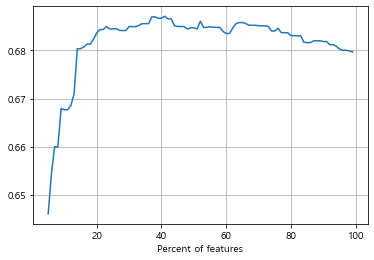

In [19]:
select_f(LogisticRegression(random_state=0),0)
X_LR_train=model_train[0]
X_LR_test=model_test[0]

  0%|          | 0/95 [00:00<?, ?it/s]

(51, 0.6268267083339477)
(3500, 37)
['총구매액', '최대구매액', '환불금액', '내점일수', '내점당구매건수', '주말방문비율', '구매주기', '주구매상품_가공식품', '주구매상품_건강식품', '주구매상품_골프', '주구매상품_구두', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_섬유잡화', '주구매상품_셔츠', '주구매상품_스포츠', '주구매상품_시티웨어', '주구매상품_식기', '주구매상품_악기', '주구매상품_육류', '주구매상품_젓갈/반찬', '주구매상품_주류', '주구매상품_주방가전', '주구매상품_침구/수예', '주구매상품_피혁잡화', '주구매상품_화장품', '주구매지점_강남점', '주구매지점_노원점', '주구매지점_대구점', '주구매지점_본  점', '주구매지점_부산본점', '주구매지점_부평점', '주구매지점_안양점', '주구매지점_영등포점', '주구매지점_전주점']


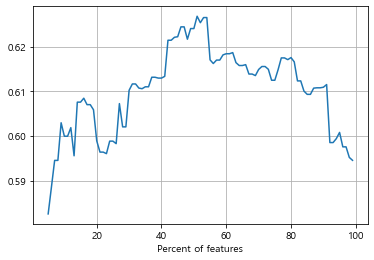

In [20]:
select_f(KNeighborsClassifier(),1)
X_KNN_train=model_train[1]
X_KNN_test=model_test[1]

  0%|          | 0/95 [00:00<?, ?it/s]

(39, 0.6641806523923025)
(3500, 29)
['총구매액', '최대구매액', '환불금액', '내점일수', '내점당구매건수', '주말방문비율', '주구매상품_가공식품', '주구매상품_건강식품', '주구매상품_골프', '주구매상품_구두', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_섬유잡화', '주구매상품_셔츠', '주구매상품_스포츠', '주구매상품_시티웨어', '주구매상품_식기', '주구매상품_악기', '주구매상품_젓갈/반찬', '주구매상품_주류', '주구매상품_주방가전', '주구매상품_화장품', '주구매지점_강남점', '주구매지점_대구점', '주구매지점_본  점', '주구매지점_안양점', '주구매지점_전주점']


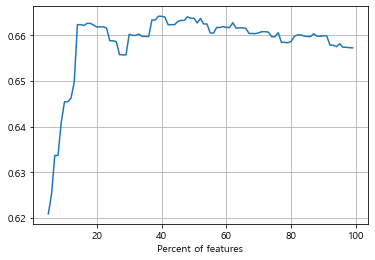

In [21]:
select_f(SVC(random_state=0),2)
X_SVC_train=model_train[2]
X_SVC_test=model_test[2]

  0%|          | 0/95 [00:00<?, ?it/s]

(71, 0.6385287241042069)
(3500, 52)
['총구매액', '최대구매액', '환불금액', '내점일수', '내점당구매건수', '주말방문비율', '구매주기', '주구매상품_가공식품', '주구매상품_가구', '주구매상품_건강식품', '주구매상품_골프', '주구매상품_구두', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_란제리/내의', '주구매상품_모피/피혁', '주구매상품_생활잡화', '주구매상품_섬유잡화', '주구매상품_셔츠', '주구매상품_스포츠', '주구매상품_시티웨어', '주구매상품_식기', '주구매상품_악기', '주구매상품_액세서리', '주구매상품_육류', '주구매상품_일용잡화', '주구매상품_젓갈/반찬', '주구매상품_주류', '주구매상품_주방가전', '주구매상품_축산가공', '주구매상품_침구/수예', '주구매상품_통신/컴퓨터', '주구매상품_트래디셔널', '주구매상품_피혁잡화', '주구매상품_화장품', '주구매지점_강남점', '주구매지점_노원점', '주구매지점_대구점', '주구매지점_미아점', '주구매지점_본  점', '주구매지점_부산본점', '주구매지점_부평점', '주구매지점_분당점', '주구매지점_상인점', '주구매지점_안양점', '주구매지점_영등포점', '주구매지점_인천점', '주구매지점_잠실점', '주구매지점_전주점', '주구매지점_청량리점']


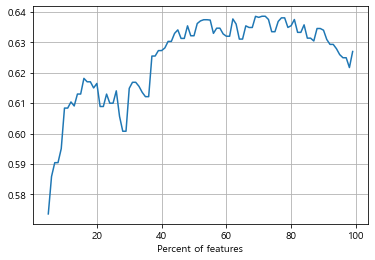

In [22]:
select_f(ExtraTreesClassifier(random_state=0),3)
X_EXT_train=model_train[3]
X_EXT_test=model_test[3]

  0%|          | 0/95 [00:00<?, ?it/s]

(21, 0.6733025353615815)
(3500, 16)
['총구매액', '최대구매액', '환불금액', '내점일수', '내점당구매건수', '주구매상품_골프', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_셔츠', '주구매상품_시티웨어', '주구매상품_주류', '주구매상품_주방가전', '주구매상품_화장품', '주구매지점_강남점']


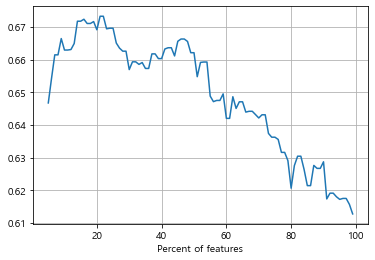

In [23]:
select_f(MLPClassifier(random_state=0),4)
X_MLP_train=model_train[4]
X_MLP_test=model_test[4]

### 4. Model Tuning (Hyperparameter Optimization)

- 각각의 모델을 모델마다 위에서의 각각의 셀렉션을 통한 훈련데이터로 튜닝

- confusion matrix 를 통해 모델 별 성능 확인

lr 모델 튜닝

In [24]:
from sklearn.linear_model import LogisticRegression
def objective(trial):
    
    lr_penalty = trial.suggest_categorical("penalty", ["l1","l2", "elasticnet"])
    lr_C = trial.suggest_categorical("C", [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,5,10,20])
    lr_fit_intercept=trial.suggest_categorical("fit_intercept",[True,False])
    lr_solver=trial.suggest_categorical("solver",["newton-cg","lbfgs","sag","saga"])

    classifier_obj = LogisticRegression(
        penalty=lr_penalty, 
        C=lr_C,
        n_jobs=-1, 
        fit_intercept=lr_fit_intercept,
        solver=lr_solver,
        random_state=0        
    )

    score = model_selection.cross_val_score(classifier_obj, X_LR_train, y_train, cv=skf, n_jobs=-1,scoring="roc_auc")
    log1 = score.mean()
    return log1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-11-23 19:01:07,938] A new study created in memory with name: no-name-61f25f77-308a-4ced-8625-1ce1835a4885
[I 2021-11-23 19:01:12,905] Trial 0 finished with value: 0.6780326030129054 and parameters: {'penalty': 'l2', 'C': 0.4, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.6780326030129054.
[I 2021-11-23 19:01:15,864] Trial 1 finished with value: 0.6870618926593354 and parameters: {'penalty': 'l2', 'C': 1, 'fit_intercept': True, 'solver': 'sag'}. Best is trial 1 with value: 0.6870618926593354.
[W 2021-11-23 19:01:18,471] Trial 2 failed, because the objective function returned nan.
[W 2021-11-23 19:01:18,502] Trial 3 failed, because the objective function returned nan.
[I 2021-11-23 19:01:18,580] Trial 4 finished with value: 0.6859685561133825 and parameters: {'penalty': 'l2', 'C': 0.3, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 1 with value: 0.6870618926593354.
[I 2021-11-23 19:01:18,693] Trial 5 finished with value: 0.6870660789329074 and

[W 2021-11-23 19:01:20,707] Trial 67 failed, because the objective function returned nan.
[W 2021-11-23 19:01:20,734] Trial 68 failed, because the objective function returned nan.
[W 2021-11-23 19:01:20,763] Trial 69 failed, because the objective function returned nan.
[W 2021-11-23 19:01:20,793] Trial 70 failed, because the objective function returned nan.
[W 2021-11-23 19:01:20,818] Trial 71 failed, because the objective function returned nan.
[W 2021-11-23 19:01:20,843] Trial 72 failed, because the objective function returned nan.
[W 2021-11-23 19:01:20,867] Trial 73 failed, because the objective function returned nan.
[W 2021-11-23 19:01:20,890] Trial 74 failed, because the objective function returned nan.
[W 2021-11-23 19:01:20,915] Trial 75 failed, because the objective function returned nan.
[W 2021-11-23 19:01:20,938] Trial 76 failed, because the objective function returned nan.
[W 2021-11-23 19:01:20,967] Trial 77 failed, because the objective function returned nan.
[W 2021-11

FrozenTrial(number=5, values=[0.6870660789329074], datetime_start=datetime.datetime(2021, 11, 23, 19, 1, 18, 582635), datetime_complete=datetime.datetime(2021, 11, 23, 19, 1, 18, 693333), params={'penalty': 'l2', 'C': 1, 'fit_intercept': True, 'solver': 'lbfgs'}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2', 'elasticnet')), 'C': CategoricalDistribution(choices=(0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10, 20)), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'solver': CategoricalDistribution(choices=('newton-cg', 'lbfgs', 'sag', 'saga'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=5, state=TrialState.COMPLETE, value=None)


#### 모델 성능 체크와 서브미션 제작 함수화

In [25]:
clfs_tunned=[]
def model_check(model,train,test,target,model_name):
  lst=[]
  scores = []
  for iter_count, (train_idx, valid_idx) in enumerate(skf.split(train, target)):
    
    X_train, X_valid =train[train_idx], train[valid_idx]
    y_train, y_valid = target.values[train_idx], target.values[valid_idx]
    
    model.fit(X_train, y_train)
    sub_pred = model.predict_proba(test)
    pred = model.predict_proba(X_valid)
    score = roc_auc_score(y_valid, pred[:,1])
    scores.append(score); lst.append(sub_pred);
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_valid, model.predict(X_valid),labels=[0,1])).plot()
    plt.show()
                           
  print(f'{model_name} 모델의 튜닝 평균 성능:  {np.mean(scores):.4f}'); print(scores)

  submission=pd.DataFrame(test_id)
  model.fit(train, target)
  y_pred=model.predict_proba(test)
  submission=pd.concat([submission,pd.DataFrame(y_pred)],axis=1)
  submission.columns = ['CLNT_ID','0','1']
  clfs_tunned.append((type(model).__name__,model,round(np.mean(scores),4)))
  return submission

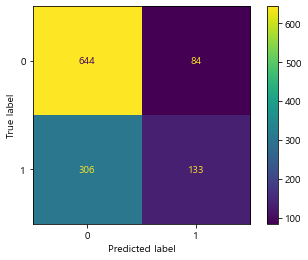

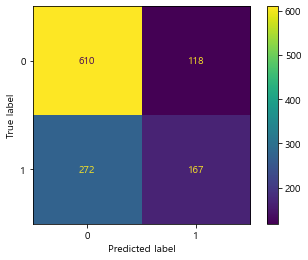

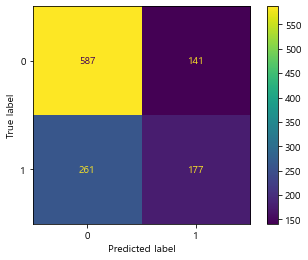

LR 모델의 튜닝 평균 성능:  0.6871
[0.7175007509574708, 0.6747869158176676, 0.6689105700235838]


,CLNT_ID,0,1
0,3500,0.496533,0.503467
1,3501,0.832465,0.167535
2,3502,0.789289,0.210711
3,3503,0.362916,0.637084
4,3504,0.522734,0.477266


In [26]:
lr_submission=model_check(LogisticRegression(**study.best_params, n_jobs=-1),X_LR_train,X_LR_test,y_train,"LR")
lr_submission.head()

- knn모델 튜닝

In [27]:
from sklearn.neighbors import KNeighborsClassifier
def objective(trial):
     
    knn_n_neighbors = trial.suggest_int("n_neighbors", 1, 300)
    knn_weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    knn_metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    knn_algorithm=trial.suggest_categorical("algorithm", ['auto','ball_tree','kd_tree','brute'])

    classifier_obj = KNeighborsClassifier(
        n_neighbors=knn_n_neighbors, 
        weights=knn_weights,
        metric=knn_metric,
        algorithm=knn_algorithm,
        n_jobs=-1        )

    score = model_selection.cross_val_score(classifier_obj,X_KNN_train, y_train, cv=skf, n_jobs=-1,scoring="roc_auc")
    log2 = score.mean()
    return log2


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-11-23 19:01:22,488] A new study created in memory with name: no-name-31f03866-56ca-4425-bfc1-957dcbb59303
[I 2021-11-23 19:01:22,799] Trial 0 finished with value: 0.6569458501084315 and parameters: {'n_neighbors': 81, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.6569458501084315.
[I 2021-11-23 19:01:23,080] Trial 1 finished with value: 0.6538754339484517 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'brute'}. Best is trial 0 with value: 0.6569458501084315.
[I 2021-11-23 19:01:23,384] Trial 2 finished with value: 0.6523336541571477 and parameters: {'n_neighbors': 183, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.6569458501084315.
[I 2021-11-23 19:01:23,567] Trial 3 finished with value: 0.6359235367654643 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 

[I 2021-11-23 19:01:31,536] Trial 33 finished with value: 0.6599114832217775 and parameters: {'n_neighbors': 137, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 33 with value: 0.6599114832217775.
[I 2021-11-23 19:01:31,783] Trial 34 finished with value: 0.659103808649788 and parameters: {'n_neighbors': 133, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 33 with value: 0.6599114832217775.
[I 2021-11-23 19:01:32,000] Trial 35 finished with value: 0.6542806928529461 and parameters: {'n_neighbors': 167, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'auto'}. Best is trial 33 with value: 0.6599114832217775.
[I 2021-11-23 19:01:32,258] Trial 36 finished with value: 0.6591152077917609 and parameters: {'n_neighbors': 132, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'kd_tree'}. Best is trial 33 with value: 0.6599114832217775.
[I 2021-11-23 19:01:32,468] Trial 37 finished with value: 0.65731074290572

[I 2021-11-23 19:01:40,088] Trial 67 finished with value: 0.655449999072257 and parameters: {'n_neighbors': 107, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 33 with value: 0.6599114832217775.
[I 2021-11-23 19:01:40,386] Trial 68 finished with value: 0.6552268240179745 and parameters: {'n_neighbors': 279, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'ball_tree'}. Best is trial 33 with value: 0.6599114832217775.
[I 2021-11-23 19:01:40,654] Trial 69 finished with value: 0.6594670250326395 and parameters: {'n_neighbors': 122, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 33 with value: 0.6599114832217775.
[I 2021-11-23 19:01:40,955] Trial 70 finished with value: 0.6569398802632411 and parameters: {'n_neighbors': 157, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 33 with value: 0.6599114832217775.
[I 2021-11-23 19:01:41,252] Trial 71 finished with value: 0.6592982608190

FrozenTrial(number=33, values=[0.6599114832217775], datetime_start=datetime.datetime(2021, 11, 23, 19, 1, 31, 293446), datetime_complete=datetime.datetime(2021, 11, 23, 19, 1, 31, 536796), params={'n_neighbors': 137, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}, distributions={'n_neighbors': IntUniformDistribution(high=300, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'metric': CategoricalDistribution(choices=('euclidean', 'manhattan', 'minkowski')), 'algorithm': CategoricalDistribution(choices=('auto', 'ball_tree', 'kd_tree', 'brute'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=33, state=TrialState.COMPLETE, value=None)


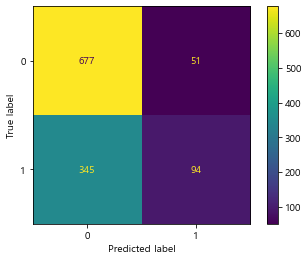

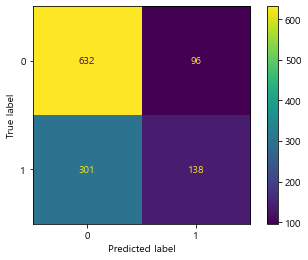

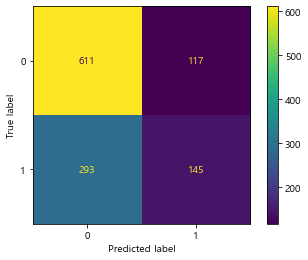

KNN 모델의 튜닝 평균 성능:  0.6599
[0.6945308393201333, 0.6515604270444817, 0.6336431833007176]


,CLNT_ID,0,1
0,3500,0.579449,0.420551
1,3501,0.808578,0.191422
2,3502,0.830832,0.169168
3,3503,0.539455,0.460545
4,3504,0.505363,0.494637


In [28]:
KNN_model_submission=model_check(KNeighborsClassifier(**study.best_params, n_jobs=-1),X_KNN_train,X_KNN_test,y_train,"KNN")
KNN_model_submission.head()

- svm 모델 튜닝

In [29]:
from sklearn.svm import SVC
def objective(trial):
     
    svm_C = trial.suggest_categorical("C", [0.01,0.1,0.5,1,2,5,10,100])
    svm_kernel = trial.suggest_categorical("kernel", ['rbf','poly','sigmoid','linear'])
    svm_degree = trial.suggest_categorical("degree", [1,2,3,4,5,6])
    svm_gamma=trial.suggest_categorical("gamma", [1, 0.1, 0.01, 0.001, 0.0001])

    classifier_obj = SVC(
        C=svm_C, 
        kernel=svm_kernel,
        degree=svm_degree,
        gamma=svm_gamma,
        random_state=0 )

    score = model_selection.cross_val_score(classifier_obj,X_SVC_train, y_train, cv=skf, n_jobs=-1,scoring="roc_auc")
    log2 = score.mean()
    return log2


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_trial)

[I 2021-11-23 19:01:51,584] A new study created in memory with name: no-name-f70066d0-20f2-403a-8034-709920a71bdc
[I 2021-11-23 19:01:52,603] Trial 0 finished with value: 0.6712228027473994 and parameters: {'C': 1, 'kernel': 'rbf', 'degree': 4, 'gamma': 0.001}. Best is trial 0 with value: 0.6712228027473994.
[I 2021-11-23 19:01:53,374] Trial 1 finished with value: 0.660158972238691 and parameters: {'C': 2, 'kernel': 'linear', 'degree': 5, 'gamma': 0.01}. Best is trial 0 with value: 0.6712228027473994.
[I 2021-11-23 19:01:54,172] Trial 2 finished with value: 0.6744907917316801 and parameters: {'C': 5, 'kernel': 'linear', 'degree': 2, 'gamma': 0.01}. Best is trial 2 with value: 0.6744907917316801.
[I 2021-11-23 19:01:55,053] Trial 3 finished with value: 0.6690575563276205 and parameters: {'C': 0.5, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 0.001}. Best is trial 2 with value: 0.6744907917316801.
[I 2021-11-23 19:01:55,820] Trial 4 finished with value: 0.6737192053144015 and parameters: {

[I 2021-11-23 19:36:19,811] Trial 39 finished with value: 0.6742086564193549 and parameters: {'C': 0.5, 'kernel': 'linear', 'degree': 3, 'gamma': 0.01}. Best is trial 8 with value: 0.679311873923499.
[I 2021-11-23 19:36:21,416] Trial 40 finished with value: 0.6192827611768933 and parameters: {'C': 100, 'kernel': 'rbf', 'degree': 5, 'gamma': 0.1}. Best is trial 8 with value: 0.679311873923499.
[I 2021-11-23 19:38:50,121] Trial 41 finished with value: 0.679311873923499 and parameters: {'C': 100, 'kernel': 'linear', 'degree': 3, 'gamma': 0.1}. Best is trial 8 with value: 0.679311873923499.
[I 2021-11-23 19:41:19,236] Trial 42 finished with value: 0.679311873923499 and parameters: {'C': 100, 'kernel': 'linear', 'degree': 5, 'gamma': 0.1}. Best is trial 8 with value: 0.679311873923499.
[I 2021-11-23 19:43:46,475] Trial 43 finished with value: 0.679311873923499 and parameters: {'C': 100, 'kernel': 'linear', 'degree': 1, 'gamma': 0.01}. Best is trial 8 with value: 0.679311873923499.
[I 2021-1

FrozenTrial(number=8, values=[0.679311873923499], datetime_start=datetime.datetime(2021, 11, 23, 19, 1, 58, 104901), datetime_complete=datetime.datetime(2021, 11, 23, 19, 4, 35, 352731), params={'C': 100, 'kernel': 'linear', 'degree': 4, 'gamma': 1}, distributions={'C': CategoricalDistribution(choices=(0.01, 0.1, 0.5, 1, 2, 5, 10, 100)), 'kernel': CategoricalDistribution(choices=('rbf', 'poly', 'sigmoid', 'linear')), 'degree': CategoricalDistribution(choices=(1, 2, 3, 4, 5, 6)), 'gamma': CategoricalDistribution(choices=(1, 0.1, 0.01, 0.001, 0.0001))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=8, state=TrialState.COMPLETE, value=None)


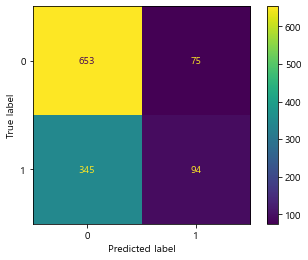

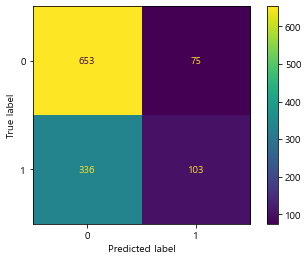

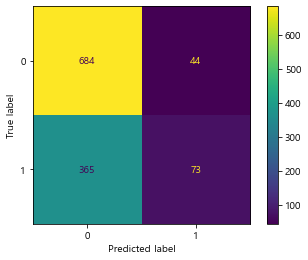

SVM 모델의 튜닝 평균 성능:  0.6793
[0.7021968635009637, 0.6634568449773461, 0.6722819132921872]


,CLNT_ID,0,1
0,3500,0.441350,0.558650
1,3501,0.648555,0.351445
2,3502,0.648531,0.351469
3,3503,0.441283,0.558717
4,3504,0.648394,0.351606


In [30]:
SVM_model_submission=model_check(SVC(**study.best_params,probability=True),X_SVC_train,X_SVC_test,y_train,"SVM")
SVM_model_submission.head()

- extra tree 모델 튜닝

In [31]:
def objective(trial):
     
    ext_n_estimators = trial.suggest_int("n_estimators", 10, 1000 )
    ext_max_features = trial.suggest_int("max_features", 1,10)
    ext_min_samples_split = trial.suggest_int("min_samples_split", 2,30)
    ext_min_samples_leaf=trial.suggest_int("min_samples_leaf", 10,100)

    classifier_obj = ExtraTreesClassifier(
        n_estimators=ext_n_estimators, 
        max_features=ext_max_features,
        min_samples_split=ext_min_samples_split,
        min_samples_leaf=ext_min_samples_leaf,
        random_state=0,
        n_jobs=-1        )

    score = model_selection.cross_val_score(classifier_obj,X_EXT_train, y_train, cv=skf, n_jobs=-1,scoring="roc_auc")
    log2 = score.mean()
    return log2


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-11-23 20:22:47,780] A new study created in memory with name: no-name-8d2b08a2-1094-4c38-84c4-12bf4a3a29ba
[I 2021-11-23 20:22:54,642] Trial 0 finished with value: 0.6645083271220273 and parameters: {'n_estimators': 511, 'max_features': 8, 'min_samples_split': 15, 'min_samples_leaf': 97}. Best is trial 0 with value: 0.6645083271220273.
[I 2021-11-23 20:22:59,504] Trial 1 finished with value: 0.6678529787293868 and parameters: {'n_estimators': 571, 'max_features': 3, 'min_samples_split': 17, 'min_samples_leaf': 69}. Best is trial 1 with value: 0.6678529787293868.
[I 2021-11-23 20:23:05,226] Trial 2 finished with value: 0.6683017529713399 and parameters: {'n_estimators': 691, 'max_features': 3, 'min_samples_split': 17, 'min_samples_leaf': 72}. Best is trial 2 with value: 0.6683017529713399.
[I 2021-11-23 20:23:06,354] Trial 3 finished with value: 0.6766915726607742 and parameters: {'n_estimators': 413, 'max_features': 3, 'min_samples_split': 21, 'min_samples_leaf': 27}. Best is tr

[I 2021-11-23 20:23:49,752] Trial 33 finished with value: 0.6769496678565781 and parameters: {'n_estimators': 435, 'max_features': 3, 'min_samples_split': 28, 'min_samples_leaf': 23}. Best is trial 14 with value: 0.6816665492224047.
[I 2021-11-23 20:23:52,342] Trial 34 finished with value: 0.6814185208477186 and parameters: {'n_estimators': 658, 'max_features': 3, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 14 with value: 0.6816665492224047.
[I 2021-11-23 20:23:54,548] Trial 35 finished with value: 0.6792303594617385 and parameters: {'n_estimators': 736, 'max_features': 3, 'min_samples_split': 9, 'min_samples_leaf': 16}. Best is trial 14 with value: 0.6816665492224047.
[I 2021-11-23 20:23:56,550] Trial 36 finished with value: 0.6787995114242501 and parameters: {'n_estimators': 678, 'max_features': 4, 'min_samples_split': 6, 'min_samples_leaf': 16}. Best is trial 14 with value: 0.6816665492224047.
[I 2021-11-23 20:23:58,823] Trial 37 finished with value: 0.66900750083

[I 2021-11-23 20:25:15,753] Trial 67 finished with value: 0.6783160218300402 and parameters: {'n_estimators': 823, 'max_features': 7, 'min_samples_split': 21, 'min_samples_leaf': 21}. Best is trial 50 with value: 0.6816925955593383.
[I 2021-11-23 20:25:18,387] Trial 68 finished with value: 0.6751912579330122 and parameters: {'n_estimators': 759, 'max_features': 9, 'min_samples_split': 22, 'min_samples_leaf': 30}. Best is trial 50 with value: 0.6816925955593383.
[I 2021-11-23 20:25:21,178] Trial 69 finished with value: 0.6771414827687646 and parameters: {'n_estimators': 861, 'max_features': 8, 'min_samples_split': 27, 'min_samples_leaf': 25}. Best is trial 50 with value: 0.6816925955593383.
[I 2021-11-23 20:25:23,441] Trial 70 finished with value: 0.6798603626777872 and parameters: {'n_estimators': 707, 'max_features': 7, 'min_samples_split': 2, 'min_samples_leaf': 14}. Best is trial 50 with value: 0.6816925955593383.
[I 2021-11-23 20:25:26,091] Trial 71 finished with value: 0.681757320

FrozenTrial(number=72, values=[0.6817948901782801], datetime_start=datetime.datetime(2021, 11, 23, 20, 25, 26, 92322), datetime_complete=datetime.datetime(2021, 11, 23, 20, 25, 28, 964639), params={'n_estimators': 767, 'max_features': 6, 'min_samples_split': 19, 'min_samples_leaf': 10}, distributions={'n_estimators': IntUniformDistribution(high=1000, low=10, step=1), 'max_features': IntUniformDistribution(high=10, low=1, step=1), 'min_samples_split': IntUniformDistribution(high=30, low=2, step=1), 'min_samples_leaf': IntUniformDistribution(high=100, low=10, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=72, state=TrialState.COMPLETE, value=None)


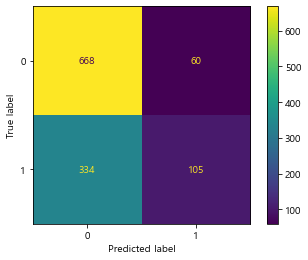

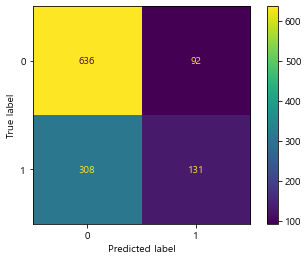

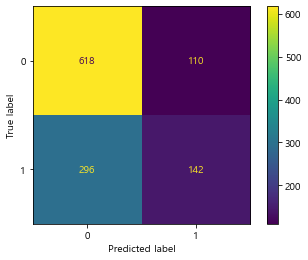

EXT 모델의 튜닝 평균 성능:  0.6806
[0.7092793311472128, 0.6749918646274, 0.6575091575091575]


,CLNT_ID,0,1
0,3500,0.567542,0.432458
1,3501,0.801165,0.198835
2,3502,0.719018,0.280982
3,3503,0.448653,0.551347
4,3504,0.504075,0.495925


In [32]:
EXT_model_submission=model_check(ExtraTreesClassifier(**study.best_params, n_jobs=-1),X_EXT_train,X_EXT_test,y_train,"EXT")
EXT_model_submission.head()

- mlp 모델 튜닝

In [33]:
from sklearn.neural_network import MLPClassifier
def objective(trial):
     
    mlp_batch_size = trial.suggest_categorical("batch_size", ['auto', 32, 64, 128])
    mlp_learning_rate = trial.suggest_categorical("learning_rate", ['constant', 'adaptive'])
    mlp_activation = trial.suggest_categorical("activation", ['tanh', 'relu'])
    mlp_solver=trial.suggest_categorical("solver", ['sgd', 'adam'])
    mlp_alpha=trial.suggest_float("alpha", 0.0001,0.05)

    classifier_obj = MLPClassifier(
        batch_size=mlp_batch_size, 
        learning_rate=mlp_learning_rate,
        activation=mlp_activation,
        solver=mlp_solver,
        alpha=mlp_alpha,
        random_state=0     )

    score = model_selection.cross_val_score(classifier_obj,X_MLP_train, y_train, cv=skf, n_jobs=-1,scoring="roc_auc")
    log2 = score.mean()
    return log2


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-11-23 20:26:34,731] A new study created in memory with name: no-name-bc211585-d16f-4f69-99f0-e64d8c86a58e
[I 2021-11-23 20:26:38,396] Trial 0 finished with value: 0.6753440962093489 and parameters: {'batch_size': 128, 'learning_rate': 'adaptive', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.041835849041378055}. Best is trial 0 with value: 0.6753440962093489.
[I 2021-11-23 20:26:41,533] Trial 1 finished with value: 0.6850461424027202 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.023198933354602568}. Best is trial 1 with value: 0.6850461424027202.
[I 2021-11-23 20:26:44,882] Trial 2 finished with value: 0.6790232067861409 and parameters: {'batch_size': 64, 'learning_rate': 'constant', 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04344230046823}. Best is trial 1 with value: 0.6850461424027202.
[I 2021-11-23 20:26:47,047] Trial 3 finished with value: 0.6651181085888312 and parameters: {'batch_size': 'a

[I 2021-11-23 20:28:07,349] Trial 30 finished with value: 0.6844488959439268 and parameters: {'batch_size': 128, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.02050557038403508}. Best is trial 1 with value: 0.6850461424027202.
[I 2021-11-23 20:28:10,461] Trial 31 finished with value: 0.6849688011175435 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.025673519630467875}. Best is trial 1 with value: 0.6850461424027202.
[I 2021-11-23 20:28:13,433] Trial 32 finished with value: 0.6848912931434307 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.035147832786326126}. Best is trial 1 with value: 0.6850461424027202.
[I 2021-11-23 20:28:16,528] Trial 33 finished with value: 0.685052362281315 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.023788294494963516}. Best 

[I 2021-11-23 20:29:47,511] Trial 60 finished with value: 0.6844384397850791 and parameters: {'batch_size': 128, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.022907051439932755}. Best is trial 41 with value: 0.6850722196961705.
[I 2021-11-23 20:29:50,474] Trial 61 finished with value: 0.6850409583768009 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.020218191370089147}. Best is trial 41 with value: 0.6850722196961705.
[I 2021-11-23 20:29:53,619] Trial 62 finished with value: 0.6850127974716469 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.019442717486184986}. Best is trial 41 with value: 0.6850722196961705.
[I 2021-11-23 20:29:56,565] Trial 63 finished with value: 0.6839041493562587 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.012662880443040186}. 

[I 2021-11-23 20:31:26,421] Trial 90 finished with value: 0.6850357457756356 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.02031681578805522}. Best is trial 41 with value: 0.6850722196961705.
[I 2021-11-23 20:31:30,050] Trial 91 finished with value: 0.6850523599000445 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.023896770444942542}. Best is trial 41 with value: 0.6850722196961705.
[I 2021-11-23 20:31:33,214] Trial 92 finished with value: 0.6850648853829728 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.023727540252615156}. Best is trial 41 with value: 0.6850722196961705.
[I 2021-11-23 20:31:36,609] Trial 93 finished with value: 0.6850085421412301 and parameters: {'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.02214736624553019}. Bes

FrozenTrial(number=41, values=[0.6850722196961705], datetime_start=datetime.datetime(2021, 11, 23, 20, 28, 47, 266430), datetime_complete=datetime.datetime(2021, 11, 23, 20, 28, 50, 208560), params={'batch_size': 32, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.023484446368412328}, distributions={'batch_size': CategoricalDistribution(choices=('auto', 32, 64, 128)), 'learning_rate': CategoricalDistribution(choices=('constant', 'adaptive')), 'activation': CategoricalDistribution(choices=('tanh', 'relu')), 'solver': CategoricalDistribution(choices=('sgd', 'adam')), 'alpha': UniformDistribution(high=0.05, low=0.0001)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=41, state=TrialState.COMPLETE, value=None)


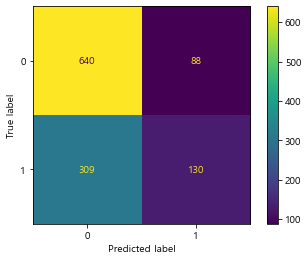

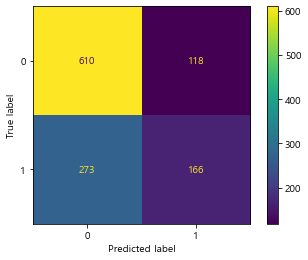

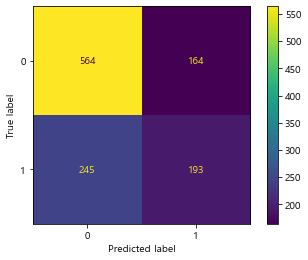

MLP 모델의 튜닝 평균 성능:  0.6836
[0.7096219554932539, 0.6790360835064707, 0.6622211977520196]


,CLNT_ID,0,1
0,3500,0.545043,0.454957
1,3501,0.837070,0.162930
2,3502,0.785498,0.214502
3,3503,0.345040,0.654960
4,3504,0.449847,0.550153


In [34]:
MLP_model_submission=model_check(MLPClassifier(**study.best_params),X_MLP_train,X_MLP_test,y_train,"MLP")
MLP_model_submission.head()

In [35]:
lr_submission.to_csv(r'lr_submission.csv',index=False)
KNN_model_submission.to_csv(r'KNN_model_submission.csv',index=False)
SVM_model_submission.to_csv(r'SVM_model_submission.csv',index=False)
EXT_model_submission.to_csv(r'EXT_model_submission.csv',index=False)
MLP_model_submission.to_csv(r'MLP_model_submission.csv',index=False)

### 5. Model Ensemble

*Correlation between models*

In [36]:
# 앙상블을 위한 파일 불러오기

lr_submission=pd.read_csv(r'lr_submission.csv')
KNN_model_submission=pd.read_csv(r'KNN_model_submission.csv')
SVM_model_submission=pd.read_csv(r'SVM_model_submission.csv')
EXT_model_submission=pd.read_csv(r'EXT_model_submission.csv')
MLP_model_submission=pd.read_csv(r'MLP_model_submission.csv')

lr_submission_1=pd.read_csv(r'lr_submission.csv').iloc[:,2]
KNN_model_submission_1=pd.read_csv(r'KNN_model_submission.csv').iloc[:,2]
SVM_model_submission_1=pd.read_csv(r'SVM_model_submission.csv').iloc[:,2]
EXT_model_submission_1=pd.read_csv(r'EXT_model_submission.csv').iloc[:,2]
MLP_model_submission_1=pd.read_csv(r'MLP_model_submission.csv').iloc[:,2]

CLNT_ID=pd.read_csv(r'lr_submission.csv').iloc[:,0]
submission_results = [lr_submission,KNN_model_submission,SVM_model_submission,EXT_model_submission,MLP_model_submission]
submission1_results = [lr_submission_1,KNN_model_submission_1,SVM_model_submission_1,EXT_model_submission_1,MLP_model_submission_1]

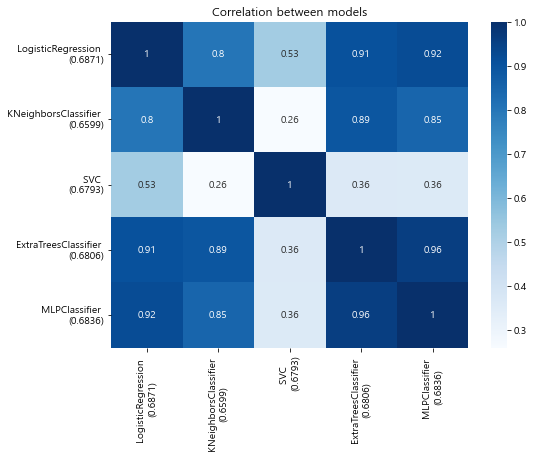

In [37]:
pred_results=[]
for i,(name, clf, clf_score) in enumerate(clfs_tunned):
    pred = submission_results[i].iloc[:,2]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

*Mean agreement vs. Performance*

In [38]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

LogisticRegression \n(0.6871)      0.789568
KNeighborsClassifier \n(0.6599)    0.701038
SVC \n(0.6793)                     0.377680
ExtraTreesClassifier \n(0.6806)    0.779767
MLPClassifier \n(0.6836)           0.771562
dtype: float64

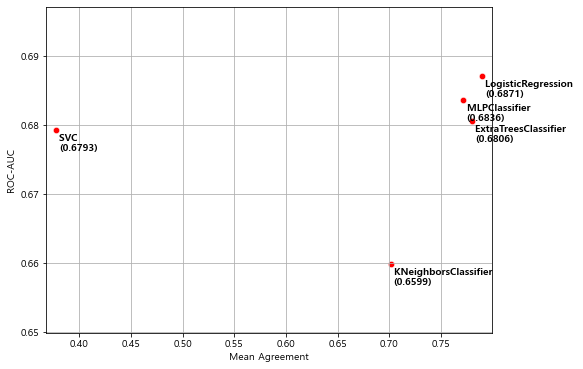

In [39]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

*Averaging Ensemble*

- model 별 선택한 훈련 데이터를 통한 averaging ensemble

In [40]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하시오.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'SVC', 
    'ExtraTreesClassifier'  ]
models_for_ensemble = [clf for clf in clfs_tunned[:5] if clf[0] in selected]

In [41]:
def model_data(x):
    if 'LogisticRegression'==x:
        return train_test_split(model_train[0],y_train,test_size=0.3,random_state=0)
    if 'KNeighborsClassifier'==x:
        return train_test_split(model_train[1],y_train,test_size=0.3,random_state=0)
    if 'SVC'==x:
        return train_test_split(model_train[2],y_train,test_size=0.3,random_state=0)
    if 'ExtraTreesClassifier'==x:
        return train_test_split(model_train[3],y_train,test_size=0.3,random_state=0)
    else:
        return train_test_split(model_train[4],y_train,test_size=0.3,random_state=0)

In [42]:
a_model=models_for_ensemble[0][1].fit(model_data('LogisticRegression')[0],model_data('LogisticRegression')[2])
b_model=models_for_ensemble[1][1].fit(model_data('KNeighborsClassifier')[0],model_data('KNeighborsClassifie')[2])
c_model=models_for_ensemble[2][1].fit(model_data('SVC')[0],model_data('SVC')[2])
d_model=models_for_ensemble[3][1].fit(model_data('ExtraTreesClassifier')[0],model_data('ExtraTreesClassifier')[2])
e_model=models_for_ensemble[4][1].fit(model_data('mlp')[0],model_data('mlp')[2])

In [43]:
k_model_list=[a_model,b_model,c_model,d_model,e_model]

In [44]:
def choose_model(x):
    if 'LogisticRegression'==x:
        return k_model_list[0]
    if 'KNeighborsClassifier'==x:
        return k_model_list[1]
    if 'SVC'==x:
        return k_model_list[2]
    if 'ExtraTreesClassifier'==x:
        return k_model_list[3]
    else:
        return k_model_list[4]

In [45]:
for p in tqdm_notebook([0, 1, 2.5]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음) 
    max_score=0
    for i in range(2, len(models_for_ensemble)+1):
        for j,models in enumerate(combinations(models_for_ensemble, i)):
            models_predict=[]
            for model in models:
                X_train1, X_dev, y_train1, y_dev = model_data(model[0])
                models_predict.append(choose_model(model[0]).predict_proba(X_dev)[:,1])
            if p==0:
                pred_mean=gmean(models_predict,axis=0)
            else:
                pred_mean=(np.sum(np.array(models_predict)**p,axis=0)/len(models))**(1/p)
            score=roc_auc_score(y_dev,pred_mean)
            if max_score<score:
                best_avg_ensemble=(p, models, score)
                max_score=score
            
    p, models, score = best_avg_ensemble
    print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

  0%|          | 0/3 [00:00<?, ?it/s]

p=0
LogisticRegression●SVC
0.6788139872622435
p=1
LogisticRegression●SVC
0.6790684292318593
p=2.5
LogisticRegression●SVC
0.6790645147400189


- 로지스틱 회귀와 서포트 벡터 머신의 앙상블이 가장 높은 성능을 보임

- make_submission 은 위에서 앙상블한 코드를 통해서 서브미션을 만들어주는 함수이다.
- make_submission의 x는 모델 선택을 의미하고 0,1,2,3,4 는 각각 lr,knn,svc,extra,mlp 를 의미한다.
- make_submission의 p는 멱평균의 p를 의미한다.

In [46]:
def make_submission(x,p):
    model=[]
    for i in x:
        model.append(submission1_results[i])
    if p==0:
        pred_mean=gmean(model,axis=0)
    else:
        pred_mean=(np.sum(np.array(model)**p,axis=0)/len(model))**(1/p)
    submission_dict={"cust_id":CLNT_ID,"gender":pred_mean}
    return pd.DataFrame(submission_dict)

In [47]:
submission=make_submission([0,2],1)
submission.to_csv(r"submission.csv",index=False)
submission

,cust_id,gender
0,3500,0.531059
1,3501,0.259490
2,3502,0.281090
3,3503,0.597900
4,3504,0.414436
...,...,...
2477,5977,0.596194
2478,5978,0.558487
2479,5979,0.631936
2480,5980,0.397593


*Stacking*

- 스태킹/ 모델별 적합 훈련 데이터로 훈련해 예측한 서브미션을 이용
- StratifiedKFold를 통해 스태킹 과적합 감소

In [48]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
  # 지정된 n_folds값으로 KFold 생성.
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
  #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
  train_fold_pred = np.zeros((X_train_n.shape[0] ,2 ))
  test_pred = np.zeros((X_test_n.shape[0],8))
  print(model.__class__.__name__ , ' model 시작 ')
    
  for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n,y_train_n)):
      #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
      print('\t 폴드 세트: ',folder_counter,' 시작 ')
      X_tr = X_train_n[train_index] 
      y_tr = y_train_n[train_index] 
      X_te = X_train_n[valid_index]  

      #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
      model.fit(X_tr , y_tr)

      #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
      train_fold_pred[valid_index, :2] = model.predict_proba(X_te).reshape(-1,2)

      #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
      test_pred[:, [(2*folder_counter)+i for i in range(2)]] = model.predict_proba(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
  sub=pd.DataFrame([x for x in range(len(pd.DataFrame(test_pred)))])
  for i in range(2):
    result=[i+2*x for x in range(4)]
    ensemble=pd.DataFrame(pd.DataFrame(test_pred).iloc[:,result].mean(axis=1))
    sub=pd.concat([sub,ensemble],axis=1)
  #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred,sub.iloc[:,1:]

In [49]:
# CV스태킹 알고리즘 각 모델에 적용
lr_train, lr_test = get_stacking_base_datasets(clfs_tunned[0][1], X_LR_train, y_train, X_LR_test,4)
knn_train, knn_test = get_stacking_base_datasets(clfs_tunned[1][1], X_KNN_train, y_train, X_KNN_test,4)
svm_train, svm_test = get_stacking_base_datasets(clfs_tunned[2][1], X_SVC_train, y_train, X_SVC_test,4)    
ext_train, ext_test = get_stacking_base_datasets(clfs_tunned[3][1], X_EXT_train, y_train, X_EXT_test,4)
mlp_train, mlp_test = get_stacking_base_datasets(clfs_tunned[4][1], X_MLP_train, y_train, X_MLP_test,4)

LogisticRegression  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
SVC  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
ExtraTreesClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
MLPClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 


In [50]:
# 스태킹을 통해 나온 훈련, 테스트 데이터
Stack_final_X_train = np.concatenate((lr_train, knn_train, svm_train, ext_train,mlp_train), axis=1)
Stack_final_X_test = np.concatenate((lr_test, knn_test, svm_test, ext_test,  mlp_test), axis=1)

#### 스태킹을 통해 나온 데이터로 메타 모델링 lr, knn, svc, extra_tree, mlp
#### 다시 한 번 메타 모델별로 튜닝을 한 다음에 예측

- 피쳐 셀력선 함수 처리

In [51]:
final_model_train=[x for x in range(10)]; final_model_test=[x for x in range(10)]
def select_f(model,number):
  # 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
  cv_scores = []
  for p in tqdm_notebook(range(5,100,1)):
      X_new = SelectPercentile(percentile=p).fit_transform(Stack_final_X_train, y_train)    
      cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=skf).mean()
      cv_scores.append((p,cv_score))

  # Print the best percentile
  best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
  print(best_score)

  # Plot the performance change with p
  plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
  plt.xlabel('Percent of features')
  plt.grid()

  # 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
  fs = SelectPercentile(percentile=best_score[0]).fit(Stack_final_X_train, y_train)
  X_train = fs.transform(Stack_final_X_train); final_model_train[number]=X_train
  X_test = fs.transform(Stack_final_X_test); final_model_test[number]=X_test

  print(X_train.shape)

  0%|          | 0/95 [00:00<?, ?it/s]

(5, 0.6861446594026867)
(3500, 1)


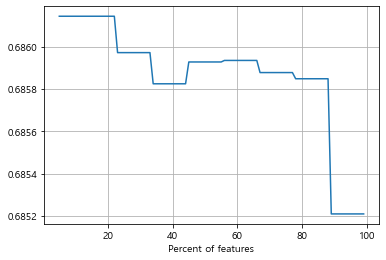

In [52]:
select_f(LogisticRegression(random_state=0),0)
X_LR_final_train=final_model_train[0]
X_LR_final_test=final_model_test[0]

In [53]:
from sklearn.linear_model import LogisticRegression
def objective(trial):
    
    lr_penalty = trial.suggest_categorical("penalty", ["l1","l2", "elasticnet"])
    lr_C = trial.suggest_categorical("C", [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,5,10,20])
    lr_fit_intercept=trial.suggest_categorical("fit_intercept",[True,False])
    lr_solver=trial.suggest_categorical("solver",["newton-cg","lbfgs","sag","saga"])

    classifier_obj = LogisticRegression(
        penalty=lr_penalty, 
        C=lr_C,
        n_jobs=-1, 
        fit_intercept=lr_fit_intercept,
        solver=lr_solver,
        random_state=0        
    )

    score = model_selection.cross_val_score(classifier_obj, X_LR_final_train, y_train, cv=skf, n_jobs=-1,scoring="roc_auc")
    log1 = score.mean()
    return log1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-11-23 21:18:15,754] A new study created in memory with name: no-name-7adcf25b-62c8-4b18-b5cd-35329894d64c
[W 2021-11-23 21:18:21,385] Trial 0 failed, because the objective function returned nan.
[I 2021-11-23 21:18:25,384] Trial 1 finished with value: 0.31385534059731335 and parameters: {'penalty': 'l2', 'C': 0.01, 'fit_intercept': False, 'solver': 'saga'}. Best is trial 1 with value: 0.31385534059731335.
[W 2021-11-23 21:18:30,146] Trial 2 failed, because the objective function returned nan.
[I 2021-11-23 21:18:30,226] Trial 3 finished with value: 0.6861446594026867 and parameters: {'penalty': 'l2', 'C': 20, 'fit_intercept': True, 'solver': 'sag'}. Best is trial 3 with value: 0.6861446594026867.
[I 2021-11-23 21:18:30,821] Trial 4 finished with value: 0.6861446594026867 and parameters: {'penalty': 'l2', 'C': 20, 'fit_intercept': True, 'solver': 'saga'}. Best is trial 3 with value: 0.6861446594026867.
[I 2021-11-23 21:18:30,901] Trial 5 finished with value: 0.6861446594026867 a

[W 2021-11-23 21:18:32,694] Trial 67 failed, because the objective function returned nan.
[W 2021-11-23 21:18:32,714] Trial 68 failed, because the objective function returned nan.
[W 2021-11-23 21:18:32,736] Trial 69 failed, because the objective function returned nan.
[W 2021-11-23 21:18:32,758] Trial 70 failed, because the objective function returned nan.
[W 2021-11-23 21:18:32,786] Trial 71 failed, because the objective function returned nan.
[W 2021-11-23 21:18:32,815] Trial 72 failed, because the objective function returned nan.
[W 2021-11-23 21:18:32,838] Trial 73 failed, because the objective function returned nan.
[W 2021-11-23 21:18:32,865] Trial 74 failed, because the objective function returned nan.
[W 2021-11-23 21:18:32,887] Trial 75 failed, because the objective function returned nan.
[W 2021-11-23 21:18:32,915] Trial 76 failed, because the objective function returned nan.
[W 2021-11-23 21:18:32,939] Trial 77 failed, because the objective function returned nan.
[W 2021-11

FrozenTrial(number=3, values=[0.6861446594026867], datetime_start=datetime.datetime(2021, 11, 23, 21, 18, 30, 148686), datetime_complete=datetime.datetime(2021, 11, 23, 21, 18, 30, 226481), params={'penalty': 'l2', 'C': 20, 'fit_intercept': True, 'solver': 'sag'}, distributions={'penalty': CategoricalDistribution(choices=('l1', 'l2', 'elasticnet')), 'C': CategoricalDistribution(choices=(0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10, 20)), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'solver': CategoricalDistribution(choices=('newton-cg', 'lbfgs', 'sag', 'saga'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=3, state=TrialState.COMPLETE, value=None)


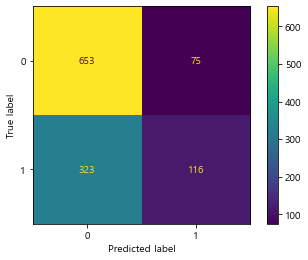

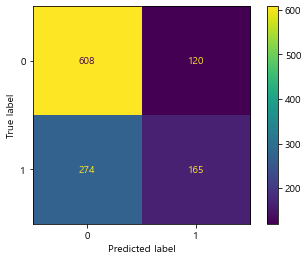

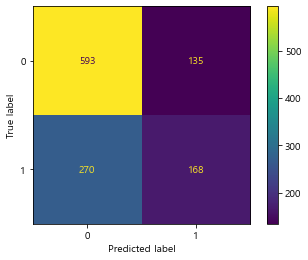

LR_Final 모델의 튜닝 평균 성능:  0.6861
[0.716180317404691, 0.6753141505419409, 0.6669395102614281]


,CLNT_ID,0,1
0,3500,0.504226,0.495774
1,3501,0.809205,0.190795
2,3502,0.779429,0.220571
3,3503,0.371614,0.628386
4,3504,0.528416,0.471584
...,...,...,...
2477,5977,0.367576,0.632424
2478,5978,0.442138,0.557862
2479,5979,0.303868,0.696132
2480,5980,0.564388,0.435612


In [54]:
lr_final_submission=model_check(LogisticRegression(**study.best_params, n_jobs=-1),X_LR_final_train,X_LR_final_test,y_train,"LR_Final")
lr_final_submission.to_csv(r'machine_submission.csv')
lr_final_submission

  0%|          | 0/95 [00:00<?, ?it/s]

(89, 0.6253416289749644)
(3500, 9)


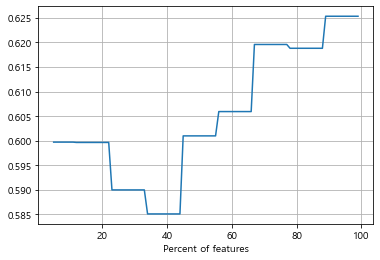

In [55]:
select_f(KNeighborsClassifier(),1)
X_KNN_final_train=final_model_train[1]
X_KNN_final_test=final_model_test[1]

In [56]:
from sklearn.neighbors import KNeighborsClassifier
def objective(trial):
     
    knn_n_neighbors = trial.suggest_int("n_neighbors", 1, 300, step=5)
    knn_weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    knn_metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    knn_algorithm=trial.suggest_categorical("algorithm", ['auto','ball_tree','kd_tree','brute'])

    classifier_obj = KNeighborsClassifier(
        n_neighbors=knn_n_neighbors, 
        weights=knn_weights,
        metric=knn_metric,
        algorithm=knn_algorithm,
        n_jobs=-1        )

    score = model_selection.cross_val_score(classifier_obj,X_KNN_final_train, y_train, cv=skf, n_jobs=-1,scoring="roc_auc")
    log2 = score.mean()
    return log2


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-11-23 21:18:43,355] A new study created in memory with name: no-name-79f6f49d-8ae4-4741-bd43-6404fab2c46c
[I 2021-11-23 21:18:43,674] Trial 0 finished with value: 0.6853579245330034 and parameters: {'n_neighbors': 216, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.6853579245330034.
[I 2021-11-23 21:18:44,254] Trial 1 finished with value: 0.6866472515489974 and parameters: {'n_neighbors': 291, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'brute'}. Best is trial 1 with value: 0.6866472515489974.
[I 2021-11-23 21:18:44,564] Trial 2 finished with value: 0.6833783243441324 and parameters: {'n_neighbors': 221, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.6866472515489974.
[I 2021-11-23 21:18:44,687] Trial 3 finished with value: 0.6781058342251668 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'auto'}. Best is trial 

[I 2021-11-23 21:18:52,913] Trial 34 finished with value: 0.6859734400992163 and parameters: {'n_neighbors': 246, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 22 with value: 0.6870543202190861.
[I 2021-11-23 21:18:53,148] Trial 35 finished with value: 0.6859051571670927 and parameters: {'n_neighbors': 281, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 22 with value: 0.6870543202190861.
[I 2021-11-23 21:18:53,333] Trial 36 finished with value: 0.6866536643105045 and parameters: {'n_neighbors': 276, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 22 with value: 0.6870543202190861.
[I 2021-11-23 21:18:53,509] Trial 37 finished with value: 0.683421821822062 and parameters: {'n_neighbors': 216, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 22 with value: 0.6870543202190861.
[I 2021-11-23 21:18:53,653] Trial 38 finished with value: 0.6854048998565255 an

[I 2021-11-23 21:18:59,149] Trial 68 finished with value: 0.6863048522330203 and parameters: {'n_neighbors': 271, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'brute'}. Best is trial 22 with value: 0.6870543202190861.
[I 2021-11-23 21:18:59,339] Trial 69 finished with value: 0.6859241168429625 and parameters: {'n_neighbors': 241, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 22 with value: 0.6870543202190861.
[I 2021-11-23 21:18:59,545] Trial 70 finished with value: 0.68647033029327 and parameters: {'n_neighbors': 296, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 22 with value: 0.6870543202190861.
[I 2021-11-23 21:18:59,771] Trial 71 finished with value: 0.6867694726396399 and parameters: {'n_neighbors': 281, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'kd_tree'}. Best is trial 22 with value: 0.6870543202190861.
[I 2021-11-23 21:19:00,001] Trial 72 finished with value: 0.687054320219086

FrozenTrial(number=22, values=[0.6870543202190861], datetime_start=datetime.datetime(2021, 11, 23, 21, 18, 50, 155086), datetime_complete=datetime.datetime(2021, 11, 23, 21, 18, 50, 436379), params={'n_neighbors': 271, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'brute'}, distributions={'n_neighbors': IntUniformDistribution(high=296, low=1, step=5), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'metric': CategoricalDistribution(choices=('euclidean', 'manhattan', 'minkowski')), 'algorithm': CategoricalDistribution(choices=('auto', 'ball_tree', 'kd_tree', 'brute'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=22, state=TrialState.COMPLETE, value=None)


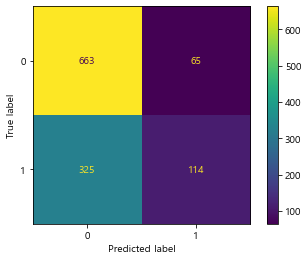

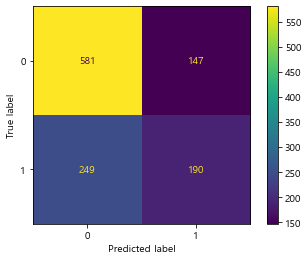

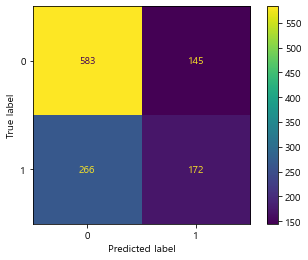

KNN 모델의 튜닝 평균 성능:  0.6871
[0.7141073618864051, 0.67989499111367, 0.667160607657183]


,CLNT_ID,0,1
0,3500,0.522010,0.477990
1,3501,0.824670,0.175330
2,3502,0.824954,0.175046
3,3503,0.419274,0.580726
4,3504,0.517641,0.482359


In [57]:
KNN_final_model_submission=model_check(KNeighborsClassifier(**study.best_params, n_jobs=-1),X_KNN_final_train,X_KNN_final_test,y_train,"KNN")
KNN_final_model_submission.head()

  0%|          | 0/95 [00:00<?, ?it/s]

(12, 0.6554292748749327)
(3500, 2)


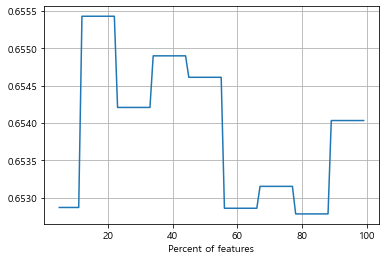

In [58]:
select_f(SVC(random_state=0),2)
X_SVC_final_train=final_model_train[2]
X_SVC_final_test=final_model_test[2]

In [59]:
from sklearn.svm import SVC
def objective(trial):
     
    svm_C = trial.suggest_categorical("C", [0.01,0.1,0.5,1,2,5,10,100])
    svm_kernel = trial.suggest_categorical("kernel", ['rbf','poly','sigmoid','linear'])
    svm_degree = trial.suggest_categorical("degree", [1,2,3,4,5,6])
    svm_gamma=trial.suggest_categorical("gamma", [1, 0.1, 0.01, 0.001, 0.0001])

    classifier_obj = SVC(
        C=svm_C, 
        kernel=svm_kernel,
        degree=svm_degree,
        gamma=svm_gamma,
        random_state=0      )

    score = model_selection.cross_val_score(classifier_obj,X_SVC_final_train, y_train, cv=skf, n_jobs=-1,scoring="roc_auc")
    log2 = score.mean()
    return log2


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-11-23 21:23:29,243] A new study created in memory with name: no-name-36664dfe-9c82-4369-b0bd-4b4d48b540ac
[I 2021-11-23 21:23:29,775] Trial 0 finished with value: 0.6745448549069012 and parameters: {'C': 100, 'kernel': 'poly', 'degree': 2, 'gamma': 1}. Best is trial 0 with value: 0.6745448549069012.
[I 2021-11-23 21:23:30,260] Trial 1 finished with value: 0.6861446594026867 and parameters: {'C': 0.01, 'kernel': 'sigmoid', 'degree': 5, 'gamma': 0.001}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:23:30,663] Trial 2 finished with value: 0.6861446594026867 and parameters: {'C': 0.01, 'kernel': 'linear', 'degree': 3, 'gamma': 0.0001}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:23:31,039] Trial 3 finished with value: 0.6861446594026867 and parameters: {'C': 0.01, 'kernel': 'poly', 'degree': 2, 'gamma': 0.01}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:23:31,475] Trial 4 finished with value: 0.6861446594026867 and parame

[I 2021-11-23 21:23:51,832] Trial 38 finished with value: 0.675212622692106 and parameters: {'C': 100, 'kernel': 'rbf', 'degree': 6, 'gamma': 0.1}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:23:52,230] Trial 39 finished with value: 0.6861446594026867 and parameters: {'C': 0.5, 'kernel': 'linear', 'degree': 2, 'gamma': 0.01}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:23:52,653] Trial 40 finished with value: 0.6861446594026867 and parameters: {'C': 100, 'kernel': 'poly', 'degree': 2, 'gamma': 0.0001}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:23:53,039] Trial 41 finished with value: 0.6861446594026867 and parameters: {'C': 0.5, 'kernel': 'poly', 'degree': 2, 'gamma': 0.01}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:23:53,481] Trial 42 finished with value: 0.6859433610806595 and parameters: {'C': 0.5, 'kernel': 'poly', 'degree': 4, 'gamma': 0.01}. Best is trial 1 with value: 0.6861446594026867.
[I 2

[I 2021-11-23 21:24:12,349] Trial 77 finished with value: 0.6861446594026867 and parameters: {'C': 0.01, 'kernel': 'poly', 'degree': 2, 'gamma': 0.001}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:24:12,764] Trial 78 finished with value: 0.5593877032447726 and parameters: {'C': 10, 'kernel': 'sigmoid', 'degree': 1, 'gamma': 1}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:24:13,161] Trial 79 finished with value: 0.6861446594026867 and parameters: {'C': 10, 'kernel': 'linear', 'degree': 5, 'gamma': 1}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:24:13,566] Trial 80 finished with value: 0.6861446594026867 and parameters: {'C': 10, 'kernel': 'linear', 'degree': 5, 'gamma': 1}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11-23 21:24:14,009] Trial 81 finished with value: 0.6861446594026867 and parameters: {'C': 10, 'kernel': 'linear', 'degree': 5, 'gamma': 1}. Best is trial 1 with value: 0.6861446594026867.
[I 2021-11

FrozenTrial(number=1, values=[0.6861446594026867], datetime_start=datetime.datetime(2021, 11, 23, 21, 23, 29, 776713), datetime_complete=datetime.datetime(2021, 11, 23, 21, 23, 30, 259680), params={'C': 0.01, 'kernel': 'sigmoid', 'degree': 5, 'gamma': 0.001}, distributions={'C': CategoricalDistribution(choices=(0.01, 0.1, 0.5, 1, 2, 5, 10, 100)), 'kernel': CategoricalDistribution(choices=('rbf', 'poly', 'sigmoid', 'linear')), 'degree': CategoricalDistribution(choices=(1, 2, 3, 4, 5, 6)), 'gamma': CategoricalDistribution(choices=(1, 0.1, 0.01, 0.001, 0.0001))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)


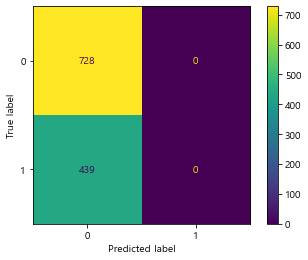

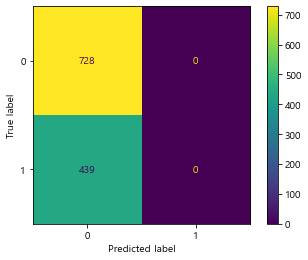

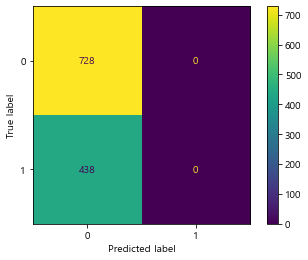

SVM 모델의 튜닝 평균 성능:  0.6861
[0.7162178652782297, 0.6752953766051716, 0.6669238295950625]


,CLNT_ID,0,1
0,3500,0.234206,0.765794
1,3501,0.778422,0.221578
2,3502,0.720003,0.279997
3,3503,0.107817,0.892183
4,3504,0.265213,0.734787


In [60]:
SVM_final_model_submission=model_check(SVC(**study.best_params,probability=True),X_SVC_final_train,X_SVC_final_test,y_train,"SVM")
SVM_final_model_submission.head()

  0%|          | 0/95 [00:00<?, ?it/s]

(89, 0.641740319840064)
(3500, 9)


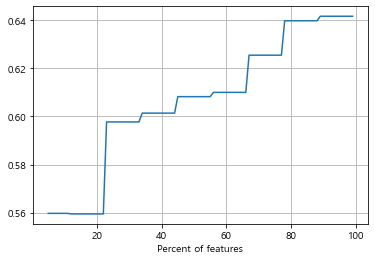

In [61]:
select_f(ExtraTreesClassifier(random_state=0),3)
X_EXT_final_train=final_model_train[3]
X_EXT_final_test=final_model_test[3]

In [62]:
def objective(trial):
     
    ext_n_estimators = trial.suggest_int("n_estimators", 10, 1000 )
    ext_max_features = trial.suggest_int("max_features", 1,10)
    ext_min_samples_split = trial.suggest_int("min_samples_split", 2,30)
    ext_min_samples_leaf=trial.suggest_int("min_samples_leaf", 10,100)

    classifier_obj = ExtraTreesClassifier(
        n_estimators=ext_n_estimators, 
        max_features=ext_max_features,
        min_samples_split=ext_min_samples_split,
        min_samples_leaf=ext_min_samples_leaf,
        random_state=0,
        n_jobs=-1        )

    score = model_selection.cross_val_score(classifier_obj,X_EXT_final_train, y_train, cv=skf, n_jobs=-1,scoring="roc_auc")
    log2 = score.mean()
    return log2


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-11-23 21:27:16,488] A new study created in memory with name: no-name-50907830-8853-4943-a61b-a3d3905678f0
[I 2021-11-23 21:27:16,691] Trial 0 finished with value: 0.6813006551008548 and parameters: {'n_estimators': 19, 'max_features': 6, 'min_samples_split': 3, 'min_samples_leaf': 23}. Best is trial 0 with value: 0.6813006551008548.
[I 2021-11-23 21:27:18,893] Trial 1 finished with value: 0.6860190533360019 and parameters: {'n_estimators': 712, 'max_features': 8, 'min_samples_split': 13, 'min_samples_leaf': 82}. Best is trial 1 with value: 0.6860190533360019.
[I 2021-11-23 21:27:21,344] Trial 2 finished with value: 0.6866866806262459 and parameters: {'n_estimators': 831, 'max_features': 1, 'min_samples_split': 23, 'min_samples_leaf': 26}. Best is trial 2 with value: 0.6866866806262459.
[W 2021-11-23 21:27:21,621] Trial 3 failed, because the objective function returned nan.
[W 2021-11-23 21:27:21,760] Trial 4 failed, because the objective function returned nan.
[I 2021-11-23 21:

[W 2021-11-23 21:28:19,714] Trial 39 failed, because the objective function returned nan.
[I 2021-11-23 21:28:22,409] Trial 40 finished with value: 0.6853588056030953 and parameters: {'n_estimators': 951, 'max_features': 4, 'min_samples_split': 28, 'min_samples_leaf': 34}. Best is trial 18 with value: 0.6871979882226551.
[I 2021-11-23 21:28:24,857] Trial 41 finished with value: 0.6866539798288481 and parameters: {'n_estimators': 875, 'max_features': 2, 'min_samples_split': 2, 'min_samples_leaf': 97}. Best is trial 18 with value: 0.6871979882226551.
[I 2021-11-23 21:28:27,364] Trial 42 finished with value: 0.6871284801268497 and parameters: {'n_estimators': 922, 'max_features': 3, 'min_samples_split': 21, 'min_samples_leaf': 77}. Best is trial 18 with value: 0.6871979882226551.
[I 2021-11-23 21:28:29,336] Trial 43 finished with value: 0.6872567258319044 and parameters: {'n_estimators': 730, 'max_features': 3, 'min_samples_split': 24, 'min_samples_leaf': 83}. Best is trial 43 with value:

[I 2021-11-23 21:29:35,299] Trial 79 finished with value: 0.6869850288188978 and parameters: {'n_estimators': 269, 'max_features': 2, 'min_samples_split': 10, 'min_samples_leaf': 63}. Best is trial 43 with value: 0.6872567258319044.
[W 2021-11-23 21:29:35,956] Trial 80 failed, because the objective function returned nan.
[W 2021-11-23 21:29:36,667] Trial 81 failed, because the objective function returned nan.
[W 2021-11-23 21:29:37,259] Trial 82 failed, because the objective function returned nan.
[I 2021-11-23 21:29:39,517] Trial 83 finished with value: 0.6868536410273937 and parameters: {'n_estimators': 851, 'max_features': 3, 'min_samples_split': 26, 'min_samples_leaf': 47}. Best is trial 43 with value: 0.6872567258319044.
[W 2021-11-23 21:29:40,185] Trial 84 failed, because the objective function returned nan.
[I 2021-11-23 21:29:42,812] Trial 85 finished with value: 0.687151036711838 and parameters: {'n_estimators': 932, 'max_features': 3, 'min_samples_split': 25, 'min_samples_lea

FrozenTrial(number=43, values=[0.6872567258319044], datetime_start=datetime.datetime(2021, 11, 23, 21, 28, 27, 366440), datetime_complete=datetime.datetime(2021, 11, 23, 21, 28, 29, 335340), params={'n_estimators': 730, 'max_features': 3, 'min_samples_split': 24, 'min_samples_leaf': 83}, distributions={'n_estimators': IntUniformDistribution(high=1000, low=10, step=1), 'max_features': IntUniformDistribution(high=10, low=1, step=1), 'min_samples_split': IntUniformDistribution(high=30, low=2, step=1), 'min_samples_leaf': IntUniformDistribution(high=100, low=10, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=43, state=TrialState.COMPLETE, value=None)


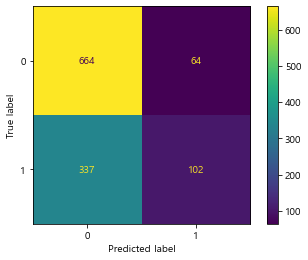

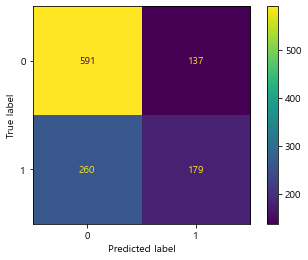

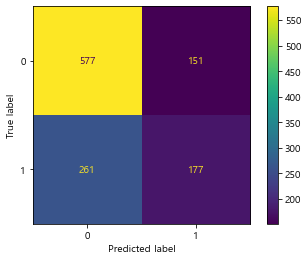

EXT 모델의 튜닝 평균 성능:  0.6867
[0.7146987408946407, 0.6799591353976321, 0.665575292287621]


,CLNT_ID,0,1
0,3500,0.532571,0.467429
1,3501,0.803999,0.196001
2,3502,0.772206,0.227794
3,3503,0.410794,0.589206
4,3504,0.493322,0.506678


In [63]:
EXT_final_model_submission=model_check(ExtraTreesClassifier(**study.best_params, n_jobs=-1),X_EXT_final_train,X_EXT_final_test,y_train,"EXT")
EXT_final_model_submission.head()

  0%|          | 0/95 [00:00<?, ?it/s]

(67, 0.686421464240956)
(3500, 7)


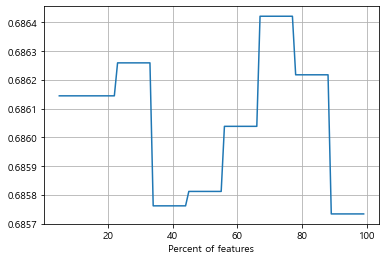

In [64]:
select_f(MLPClassifier(random_state=0),4)
X_MLP_final_train=final_model_train[4]
X_MLP_final_test=final_model_test[4]

In [65]:
from sklearn.neural_network import MLPClassifier
def objective(trial):
     
    mlp_batch_size = trial.suggest_categorical("batch_size", ['auto', 32, 64, 128])
    mlp_learning_rate = trial.suggest_categorical("learning_rate", ['constant', 'adaptive'])
    mlp_activation = trial.suggest_categorical("activation", ['tanh', 'relu'])
    mlp_solver=trial.suggest_categorical("solver", ['sgd', 'adam'])
    mlp_alpha=trial.suggest_float("alpha", 0.0001,0.05)

    classifier_obj = MLPClassifier(
        batch_size=mlp_batch_size, 
        learning_rate=mlp_learning_rate,
        activation=mlp_activation,
        solver=mlp_solver,
        alpha=mlp_alpha,
        random_state=0     )

    score = model_selection.cross_val_score(classifier_obj,X_MLP_final_train, y_train, cv=skf, n_jobs=-1,scoring="roc_auc")
    log2 = score.mean()
    return log2


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-11-23 21:32:42,969] A new study created in memory with name: no-name-dcfc422d-bb98-4e8a-a329-d72729ec29ac
[I 2021-11-23 21:32:45,211] Trial 0 finished with value: 0.6865883770166933 and parameters: {'batch_size': 128, 'learning_rate': 'constant', 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.008386127430884821}. Best is trial 0 with value: 0.6865883770166933.
[I 2021-11-23 21:32:48,023] Trial 1 finished with value: 0.6865809284025107 and parameters: {'batch_size': 128, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.03953301832315368}. Best is trial 0 with value: 0.6865883770166933.
[I 2021-11-23 21:32:49,866] Trial 2 finished with value: 0.686574732336621 and parameters: {'batch_size': 64, 'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.018260367108840676}. Best is trial 0 with value: 0.6865883770166933.
[I 2021-11-23 21:32:50,950] Trial 3 finished with value: 0.686067805087331 and parameters: {'batch_size': 64,

[I 2021-11-23 21:33:48,285] Trial 30 finished with value: 0.6866257439136726 and parameters: {'batch_size': 'auto', 'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00047417012982044833}. Best is trial 25 with value: 0.6866278322879175.
[I 2021-11-23 21:33:50,155] Trial 31 finished with value: 0.6866257439136726 and parameters: {'batch_size': 'auto', 'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001468509440631848}. Best is trial 25 with value: 0.6866278322879175.
[I 2021-11-23 21:33:52,057] Trial 32 finished with value: 0.6866257439136726 and parameters: {'batch_size': 'auto', 'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00041434185556666345}. Best is trial 25 with value: 0.6866278322879175.
[I 2021-11-23 21:33:54,051] Trial 33 finished with value: 0.6866257439136726 and parameters: {'batch_size': 'auto', 'learning_rate': 'constant', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.000347

[I 2021-11-23 21:34:59,358] Trial 60 finished with value: 0.6862409758419915 and parameters: {'batch_size': 128, 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.009034535892480863}. Best is trial 51 with value: 0.6866309708024612.
[I 2021-11-23 21:35:02,184] Trial 61 finished with value: 0.6866309708024612 and parameters: {'batch_size': 'auto', 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.002833966044460288}. Best is trial 51 with value: 0.6866309708024612.
[I 2021-11-23 21:35:05,175] Trial 62 finished with value: 0.6866309708024612 and parameters: {'batch_size': 'auto', 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0033327313291387555}. Best is trial 51 with value: 0.6866309708024612.
[I 2021-11-23 21:35:07,859] Trial 63 finished with value: 0.6866309708024612 and parameters: {'batch_size': 'auto', 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00322216291

[I 2021-11-23 21:36:22,233] Trial 90 finished with value: 0.6865423756328131 and parameters: {'batch_size': 'auto', 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.005746376231198316}. Best is trial 51 with value: 0.6866309708024612.
[I 2021-11-23 21:36:25,298] Trial 91 finished with value: 0.6866299278059739 and parameters: {'batch_size': 'auto', 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.009708643362510745}. Best is trial 51 with value: 0.6866309708024612.
[I 2021-11-23 21:36:27,910] Trial 92 finished with value: 0.6866309708024612 and parameters: {'batch_size': 'auto', 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.004151964407700767}. Best is trial 51 with value: 0.6866309708024612.
[I 2021-11-23 21:36:30,569] Trial 93 finished with value: 0.6866309708024612 and parameters: {'batch_size': 'auto', 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.004283697

FrozenTrial(number=51, values=[0.6866309708024612], datetime_start=datetime.datetime(2021, 11, 23, 21, 34, 33, 833516), datetime_complete=datetime.datetime(2021, 11, 23, 21, 34, 36, 528324), params={'batch_size': 'auto', 'learning_rate': 'adaptive', 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.006870142684221847}, distributions={'batch_size': CategoricalDistribution(choices=('auto', 32, 64, 128)), 'learning_rate': CategoricalDistribution(choices=('constant', 'adaptive')), 'activation': CategoricalDistribution(choices=('tanh', 'relu')), 'solver': CategoricalDistribution(choices=('sgd', 'adam')), 'alpha': UniformDistribution(high=0.05, low=0.0001)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=51, state=TrialState.COMPLETE, value=None)


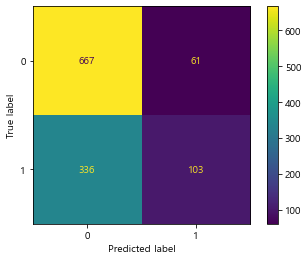

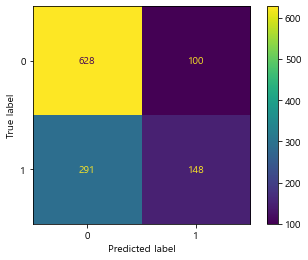

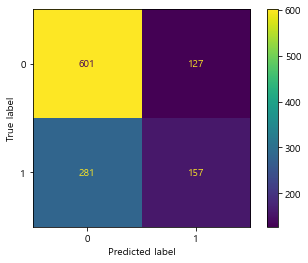

MLP 모델의 튜닝 평균 성능:  0.6866
[0.7157062755012641, 0.6793161280632807, 0.6648931833007177]


,CLNT_ID,0,1
0,3500,0.555948,0.444052
1,3501,0.791105,0.208895
2,3502,0.758969,0.241031
3,3503,0.414109,0.585891
4,3504,0.511643,0.488357
...,...,...,...
2477,5977,0.433663,0.566337
2478,5978,0.453356,0.546644
2479,5979,0.405875,0.594125
2480,5980,0.580541,0.419459


In [66]:
MLP_final_model_submission=model_check(MLPClassifier(**study.best_params),X_MLP_final_train,X_MLP_final_test,y_train,"MLP")
MLP_final_model_submission

In [67]:
models_for_ensemble = [clf for clf in clfs_tunned[5:] if clf[0] in selected]

<font color="#CC3D3D"><p>
# End

#### 다양한 모델들을 통한 스태킹 후 앙상블

In [68]:
def final_model_data(x):
    if 'LogisticRegression'==x:
        return train_test_split(final_model_train[0],y_train,test_size=0.3,random_state=0)
    if 'KNeighborsClassifier'==x:
        return train_test_split(final_model_train[1],y_train,test_size=0.3,random_state=0)
    if 'SVC'==x:
        return train_test_split(final_model_train[2],y_train,test_size=0.3,random_state=0)
    if 'ExtraTreesClassifier'==x:
        return train_test_split(final_model_train[3],y_train,test_size=0.3,random_state=0)
    else:
        return train_test_split(final_model_train[4],y_train,test_size=0.3,random_state=0)

In [76]:
a_final_model=models_for_ensemble[0][1].fit(final_model_data('LogisticRegression')[0],final_model_data('LogisticRegression')[2])
b_final_model=models_for_ensemble[1][1].fit(final_model_data('KNeighborsClassifier')[0],final_model_data('KNeighborsClassifier')[2])
c_final_model=models_for_ensemble[2][1].fit(final_model_data('SVC')[0],final_model_data('SVC')[2])
d_final_model=models_for_ensemble[3][1].fit(final_model_data('ExtraTreesClassifier')[0],final_model_data('ExtraTreesClassifier')[2])
e_final_model=models_for_ensemble[4][1].fit(final_model_data('mlp')[0],final_model_data('mlp')[2])

In [77]:
k_model_list=[a_final_model,b_final_model,c_final_model,d_final_model,e_final_model]

In [78]:
for p in tqdm_notebook([0, 1, 2.5]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음) 
    max_score=0
    for i in range(2, len(models_for_ensemble)+1):
        for j,models in enumerate(combinations(models_for_ensemble, i)):
            models_predict=[]
            for model in models:
                X_train1, X_dev, y_train1, y_dev = final_model_data(model[0])
                models_predict.append(choose_model(model[0]).predict_proba(X_dev)[:,1])
            if p==0:
                pred_mean=gmean(models_predict,axis=0)
            else:
                pred_mean=(np.sum(np.array(models_predict)**p,axis=0)/len(models))**(1/p)
            score=roc_auc_score(y_dev,pred_mean)
            if max_score<score:
                best_avg_ensemble=(p, models, score)
                max_score=score

    p, models, score = best_avg_ensemble
    print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

  0%|          | 0/3 [00:00<?, ?it/s]

p=0
LogisticRegression●KNeighborsClassifier●SVC●ExtraTreesClassifier●MLPClassifier
0.6750541178496914
p=1
LogisticRegression●KNeighborsClassifier●MLPClassifier
0.6745100034838978
p=2.5
LogisticRegression●KNeighborsClassifier●MLPClassifier
0.6741890151529979


- 스태킹 한 후 앙상블 한 결과 그 전보다 성능이 떨어지는 모습을 보임

### 모델 점수 정리

In [79]:
for i in range(5):
    print(f'{clfs_tunned[i][0]}의 스태킹 전 점수 : {clfs_tunned[i][2]},   스태킹 후 점수 : {clfs_tunned[i+5][2]}')

LogisticRegression의 스태킹 전 점수 : 0.6871,   스태킹 후 점수 : 0.6861
KNeighborsClassifier의 스태킹 전 점수 : 0.6599,   스태킹 후 점수 : 0.6871
SVC의 스태킹 전 점수 : 0.6793,   스태킹 후 점수 : 0.6861
ExtraTreesClassifier의 스태킹 전 점수 : 0.6806,   스태킹 후 점수 : 0.6867
MLPClassifier의 스태킹 전 점수 : 0.6836,   스태킹 후 점수 : 0.6866


#### 앙상블 모델 점수
- p=0 LogisticRegression●SVC 0.6788139872622435
- p=1 LogisticRegression●SVC 0.6790684292318593
- p=2.5 LogisticRegression●SVC 0.6790645147400189

#### 스태킹 후 앙상블 모델 점수
- p=0 LogisticRegression●KNeighborsClassifier●SVC●ExtraTreesClassifier●MLPClassifier 0.6750541178496914
- p=1 LogisticRegression●KNeighborsClassifier●MLPClassifier 0.6745100034838978
- p=2.5 LogisticRegression●KNeighborsClassifier●MLPClassifier 0.6741890151529979

- 가장 점수가 좋은 모델은 0.6871로 knn을 이용한 스태킹 모델이 가장 점수가 높다.
- 튜닝에 따라 점수가 약간씩 바뀌지만 메타 모델이 knn인 스태킹 모델이 0.6871 ~ 0.6889 점수를 유지하며 가장 높다.

In [80]:
final_submission=KNN_final_model_submission[["CLNT_ID","1"]].rename(columns={"CLNT_ID":"cust_id","1":"gender"})
final_submission

,cust_id,gender
0,3500,0.477990
1,3501,0.175330
2,3502,0.175046
3,3503,0.580726
4,3504,0.482359
...,...,...
2477,5977,0.547920
2478,5978,0.545817
2479,5979,0.631017
2480,5980,0.427822


In [81]:
final_submission.to_csv(r"홍종현-2차-submission-02.csv",index=False)

- 서로 알고리즘이 다른 모델 이용 lr, knn, svm, extra tree, mlp

- 모델 별 피쳐 셀렉션과 튜닝을 통하여 적합한 모델별 적합한 모델링을 진행할 수 있었음

- 서브미션 앙상블과 스태킹을 이용하여 더 좋은 모델 생성

- 스태킹 후 서비미션 앙상블 이용